In [303]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
import inspect


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(context='talk', style='whitegrid', palette='pastel')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.family'] = 'HSE Slab'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelweight'] =  'bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 25
plt.rc('axes', unicode_minus=False)


cols = [
        "stand_rrg_sdnn",
        "stand_rrg_rmssd",
        "stand_rrg_nn50",
        "stand_rrg_pnn50",
        "lying_rrg_sdnn",
        "lying_rrg_rmssd",
        "lying_rrg_nn50",
        "lying_rrg_pnn50",
        "d_sdnn",
        "d_rmssd",
        "d_nn50",
        "d_pnn50"
    ]


In [306]:
def get_variable_name(variable):
    frame = inspect.currentframe().f_back
    for name, value in frame.f_locals.items():
        if value is variable:
            return name
    return None


def func(lst, metr):
    if isinstance(lst, float):
        return None
    series = pd.Series(ast.literal_eval(lst))
    series = series[series >= 0]
    if metr == "sdnn":
        return series.std()
    elif metr == "rmssd":
        return np.sqrt(np.mean(series.diff() ** 2))
    elif metr == "nn50":
        return np.sum(series.diff().abs() > 0.05)
    elif metr == "pnn50":
        return (np.sum(series.diff().abs() > 0.05)) / (len(series) - 1) * 100
    else:
        return None


def calc_all_cells(data, func):
    metr = ["sdnn", "rmssd", "nn50", "pnn50"]
    typ = ["stand_rrg", "lying_rrg", "stand_rrn", "lying_rrn"]
    for i in typ:
        for j in metr:
            data[i + "_" + j] = data[i].map(lambda x: func(x, j))
    for i in [
        ["stand_rrg_sdnn", "lying_rrg_sdnn", "d_sdnn"],
        ["stand_rrg_rmssd", "lying_rrg_rmssd", "d_rmssd"],
        ["stand_rrg_nn50", "lying_rrg_nn50", "d_nn50"],
        ["stand_rrg_pnn50", "lying_rrg_pnn50", "d_pnn50"],
    ]:
        data[i[2]] = dif_stand_lying(data, i)
    return data


def dif_stand_lying(data, cols):
    return (data[cols[0]] - data[cols[1]]).abs()


def calc_median_cols(data):
    return [data[i].median() if not data[i].isna().all() else np.nan for i in cols]


def make_kde(datas, labels, col):
    for da, la in zip(datas, labels):
        sns.kdeplot(da[col], label=la, warn_singular=False)
    plt.legend()
    plt.show()


def normal_means(s, choice_iterations=10000, 
                 sample_size=100, shapiro_iterations=50) -> float:

    unique_elems = s.unique()
    arr = pd.Series([np.random.choice(unique_elems, len(s)).mean() 
                 for _ in range(choice_iterations)])
    return np.mean([shapiro(arr.sample(sample_size))[1] 
                    for _ in range(shapiro_iterations)])



def make_t_table(s1, s2):
    if (normal_means(s1) >= 0.05) and (normal_means(s2) >= 0.05):
        return ttest_ind(s1, s2, equal_var=(levene(s1, s2)[-1] >= 0.5))[-1]
    else:
        return None

In [307]:
ahnc = pd.read_csv('arterial_hypertension.csv')
ahnc = calc_all_cells(ahnc, func)

hnc = pd.read_csv('healthy.csv')
hnc = calc_all_cells(hnc, func)

mi6nc = pd.read_csv('myocardial_infarction_6mo.csv')
mi6nc = calc_all_cells(mi6nc, func)

minc = pd.read_csv('myocardial_infarction.csv')
minc = calc_all_cells(minc, func)
datas = [ahnc, hnc, mi6nc, minc]

ahnc.to_csv('arterial_hypertension_new_cols.csv')
hnc.to_csv('healthy_new_cols.csv')
mi6nc.to_csv('myocardial_infarction_6mo_new_cols.csv')
minc.to_csv('myocardial_infarction_new_cols.csv')


In [301]:
median_df = pd.DataFrame(
    {
        "ahnc": calc_median_cols(ahnc),
        "mi6nc": calc_median_cols(mi6nc),
        "minc": calc_median_cols(minc),
        "hnc": calc_median_cols(hnc),
    },
    index=cols,
)
median_df

,ahnc,mi6nc,minc,hnc
stand_rrg_sdnn,0.043639,0.031103,NaN,0.047793
stand_rrg_rmssd,0.029463,0.030292,NaN,0.026852
stand_rrg_nn50,21.000000,16.500000,NaN,21.000000
stand_rrg_pnn50,2.376426,2.339064,NaN,1.879045
lying_rrg_sdnn,0.047744,0.036520,0.046748,0.059942
lying_rrg_rmssd,0.043502,0.040789,0.053902,0.050033
lying_rrg_nn50,61.000000,28.000000,51.000000,111.000000
lying_rrg_pnn50,8.393638,3.645833,7.115629,12.964931
d_sdnn,0.010622,0.007231,NaN,0.017829
d_rmssd,0.018017,0.013972,NaN,0.013424


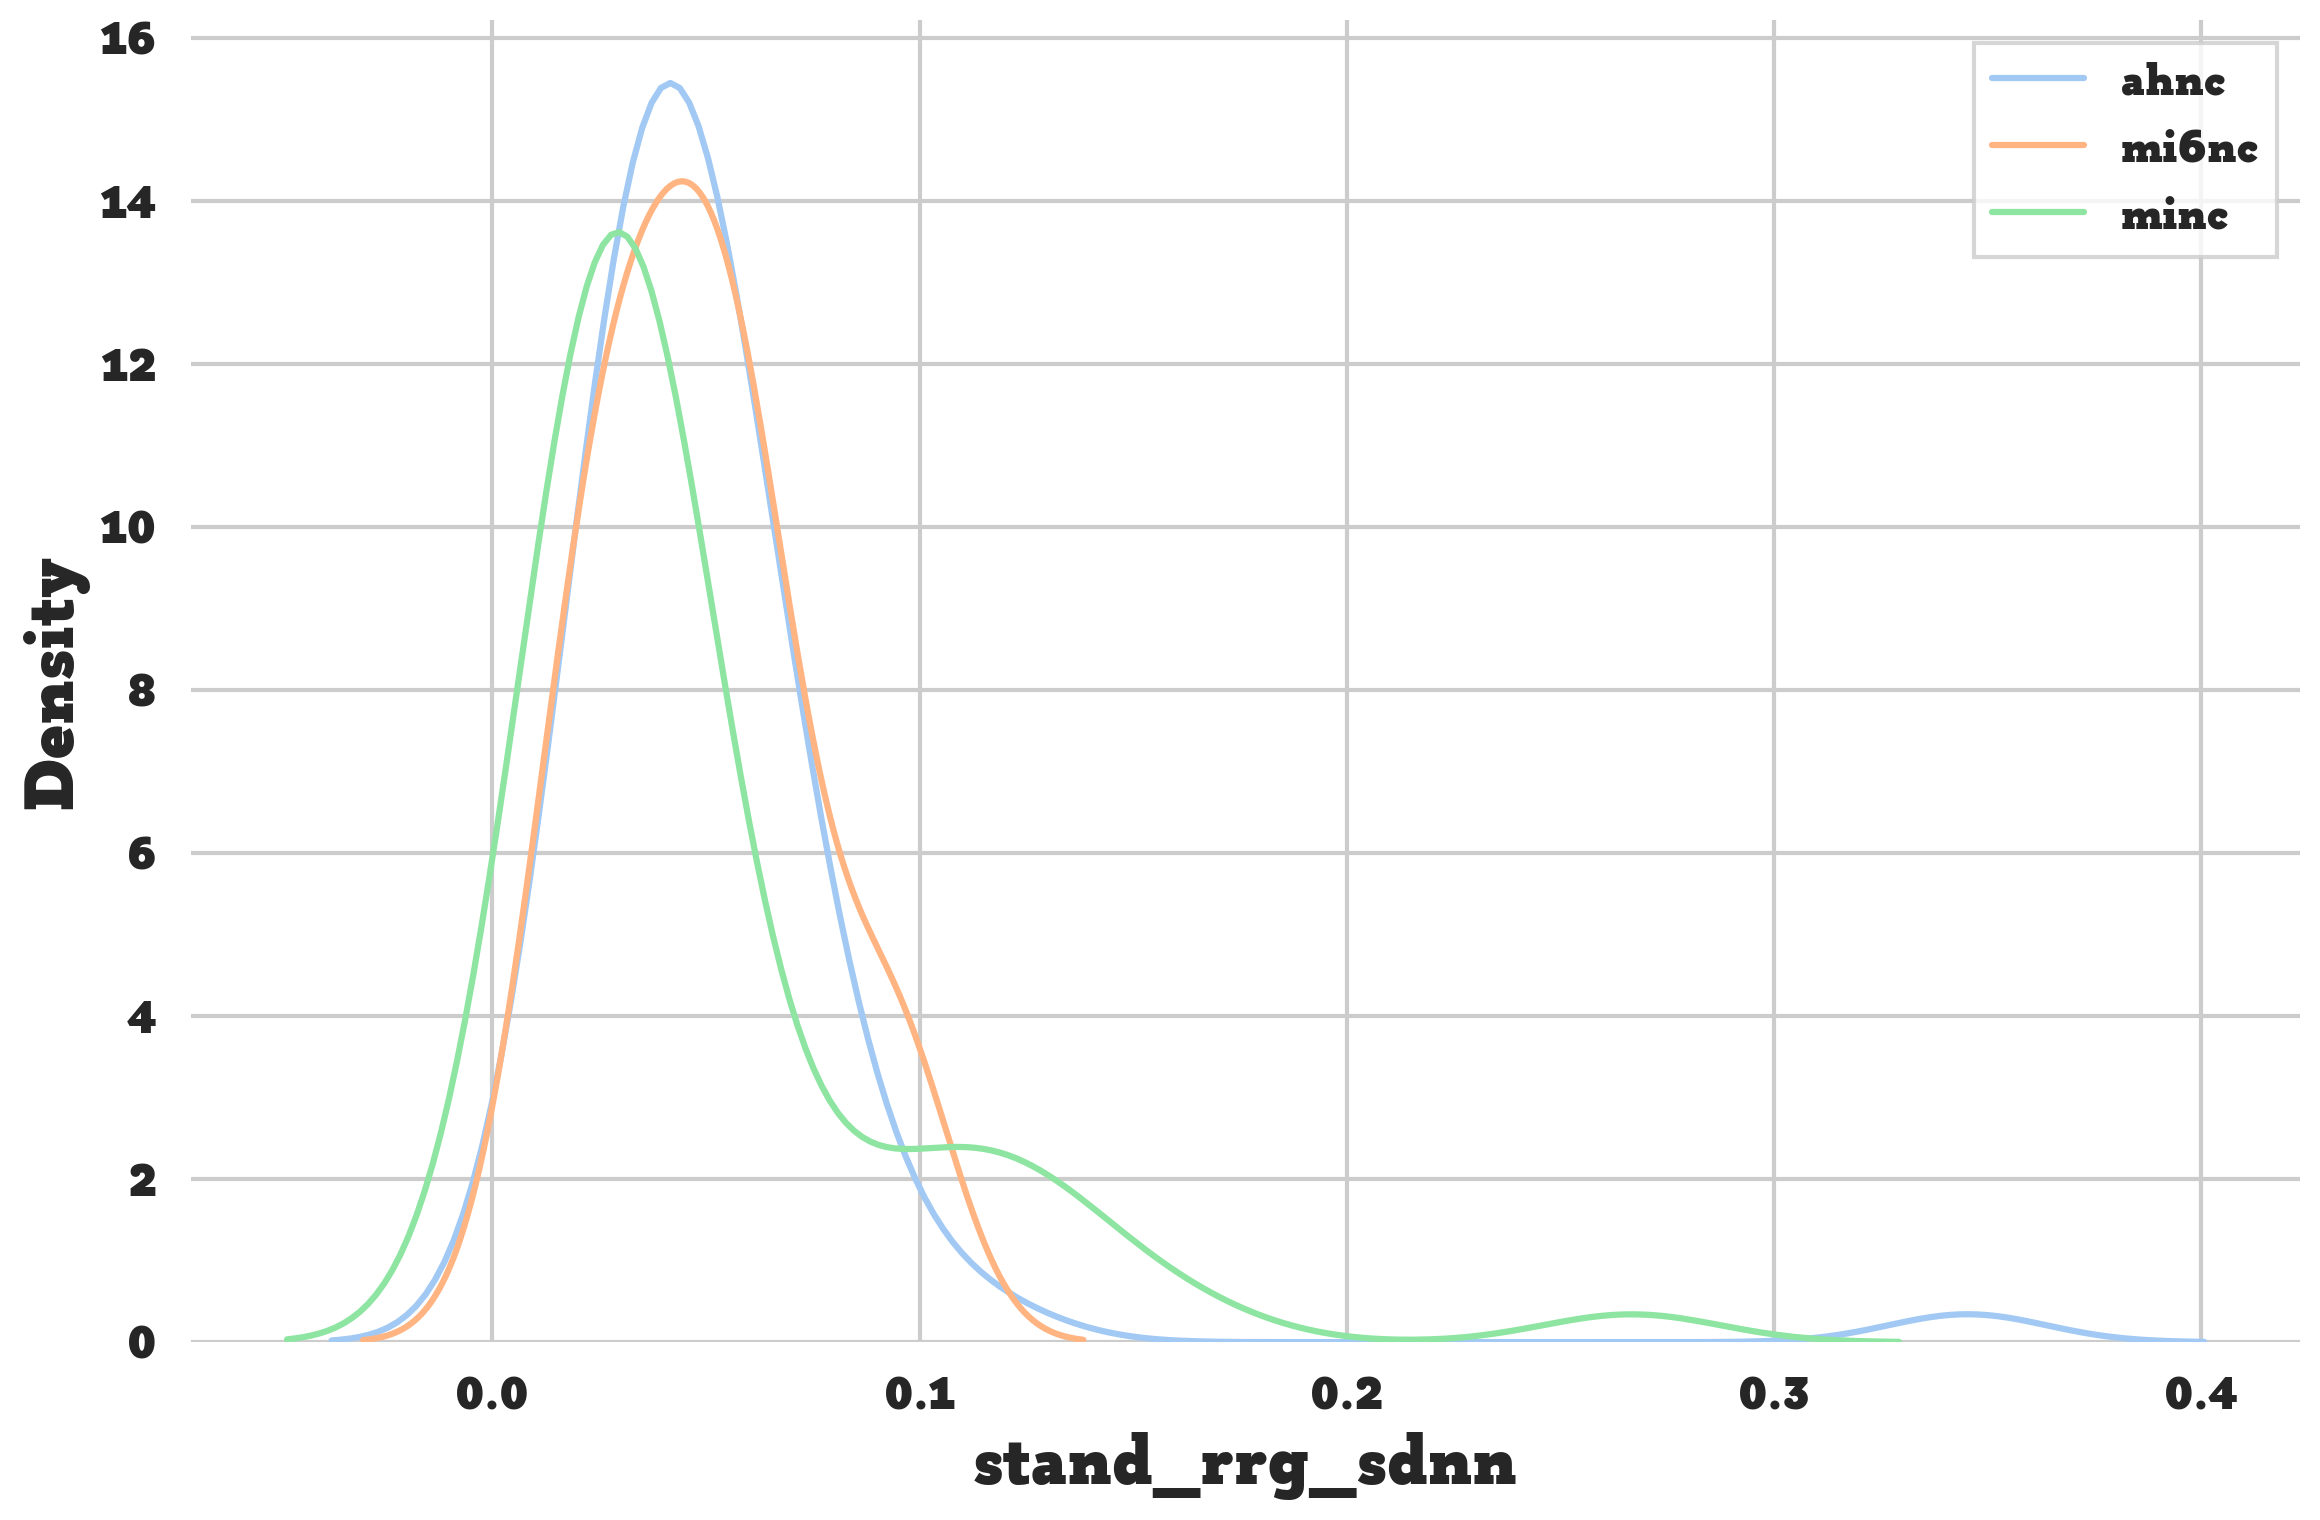

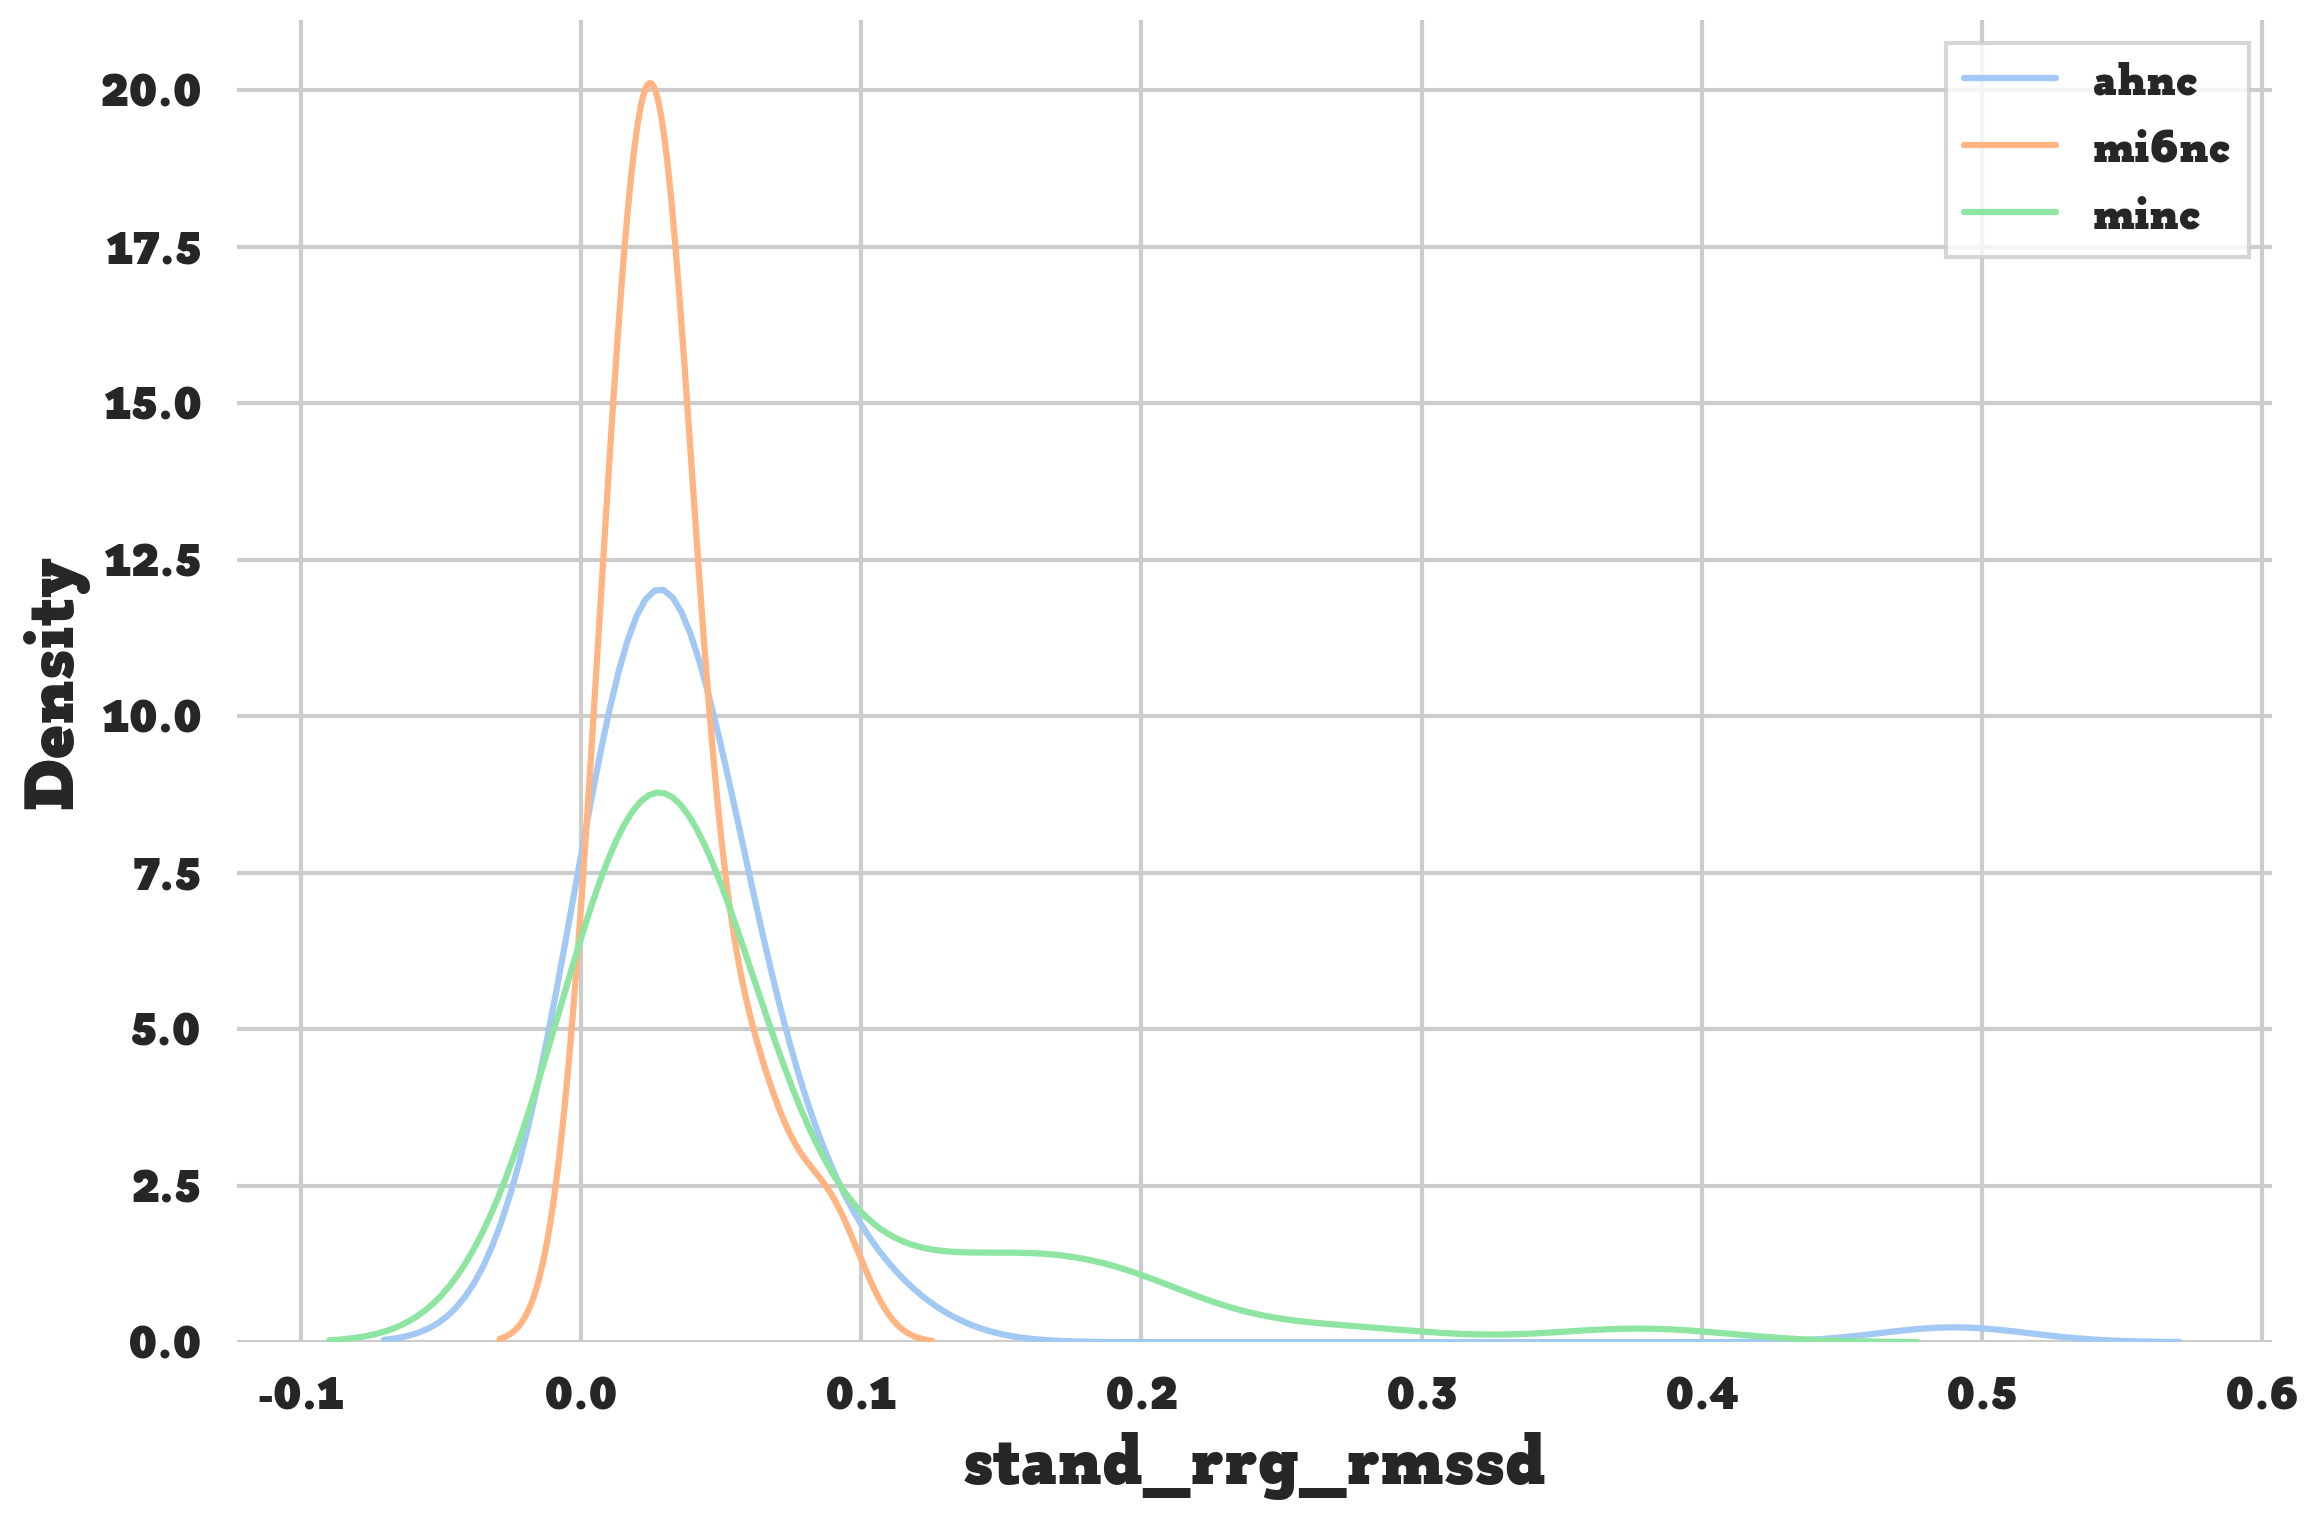

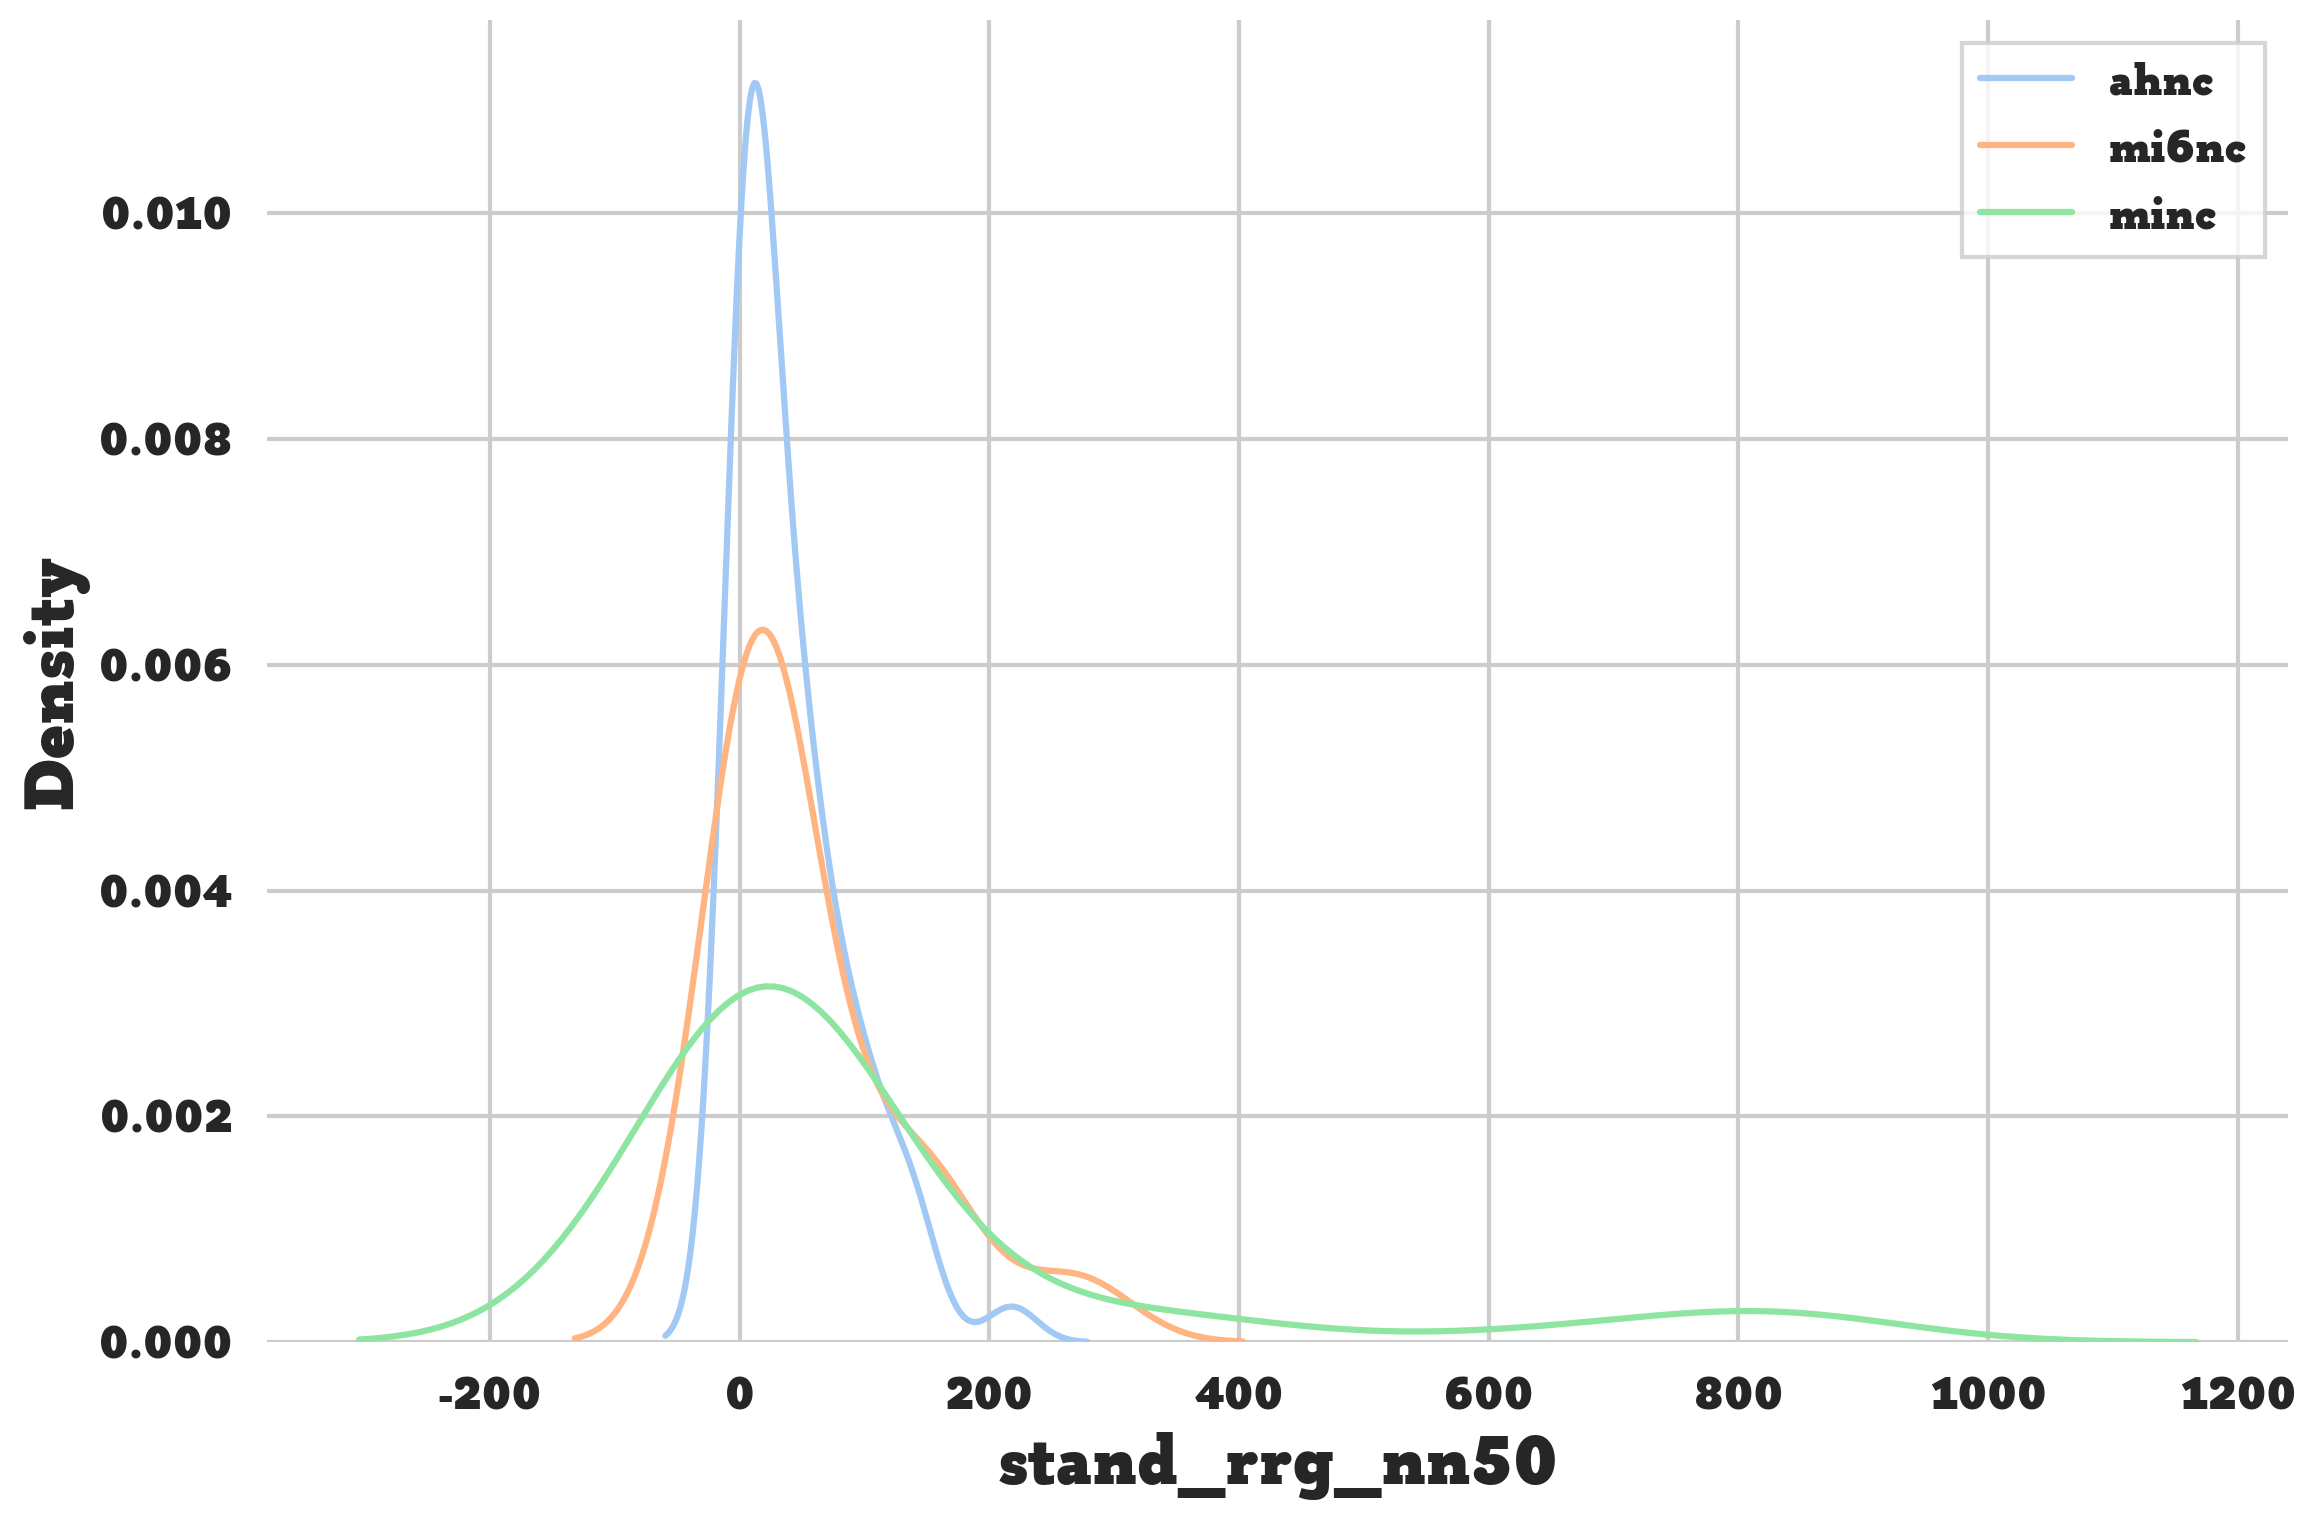

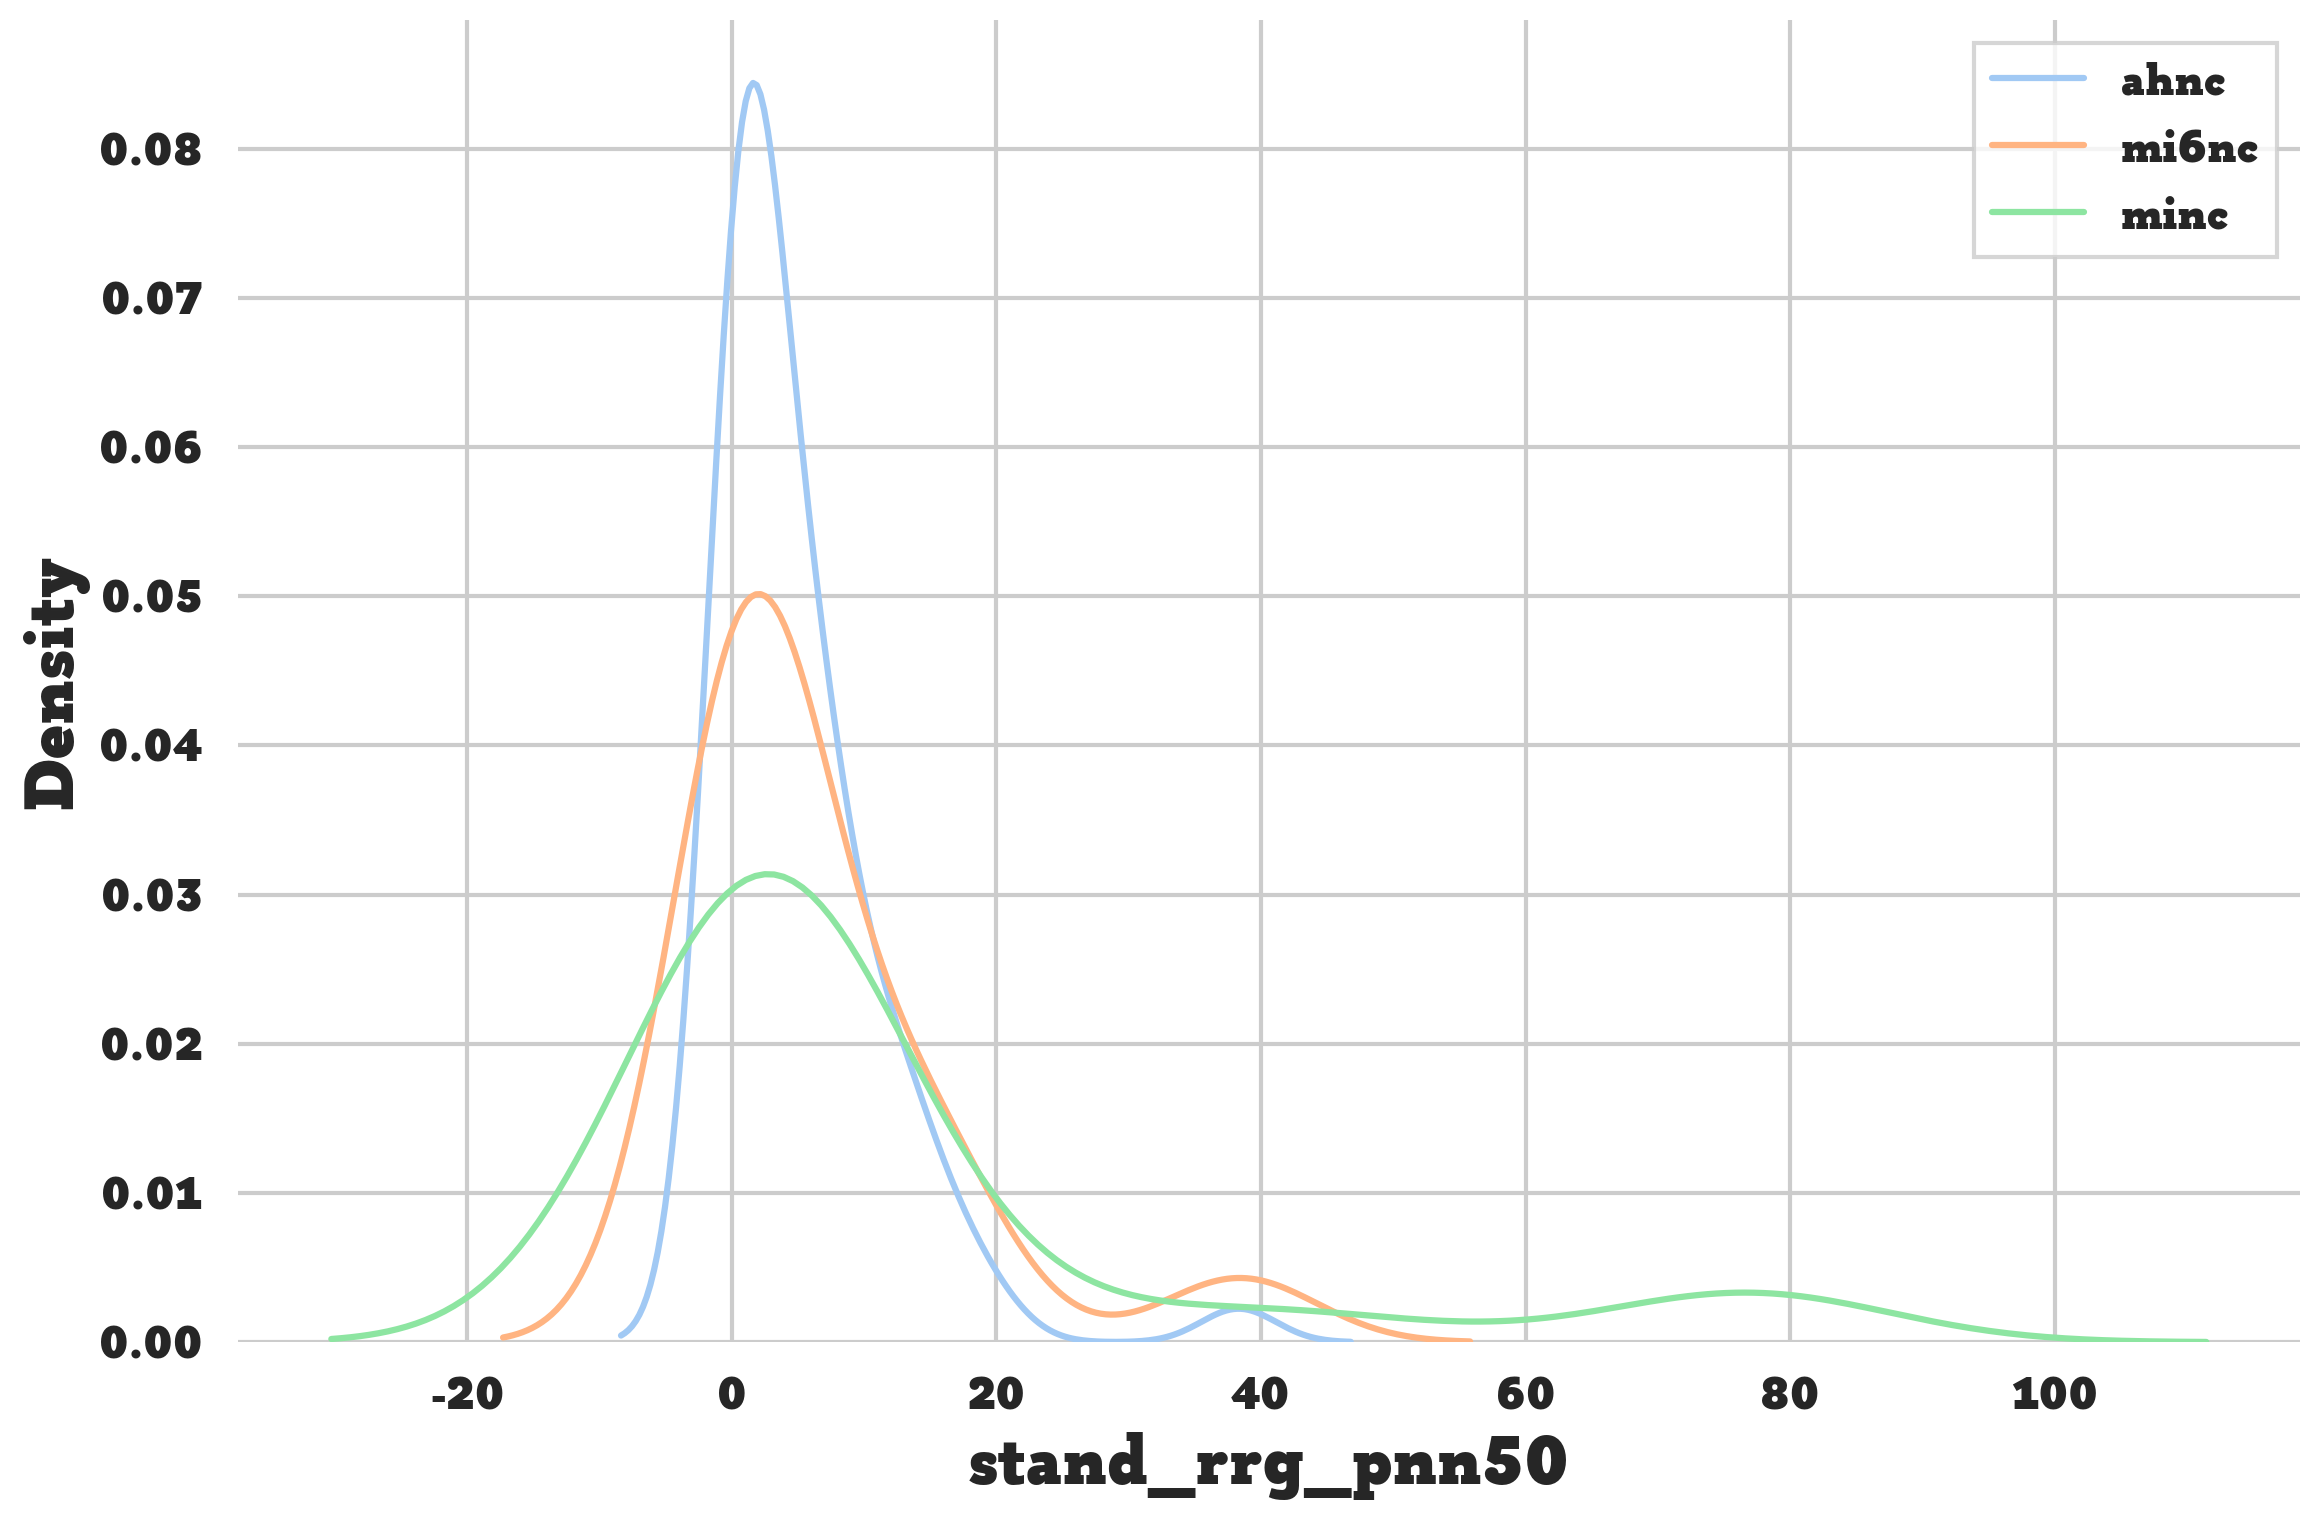

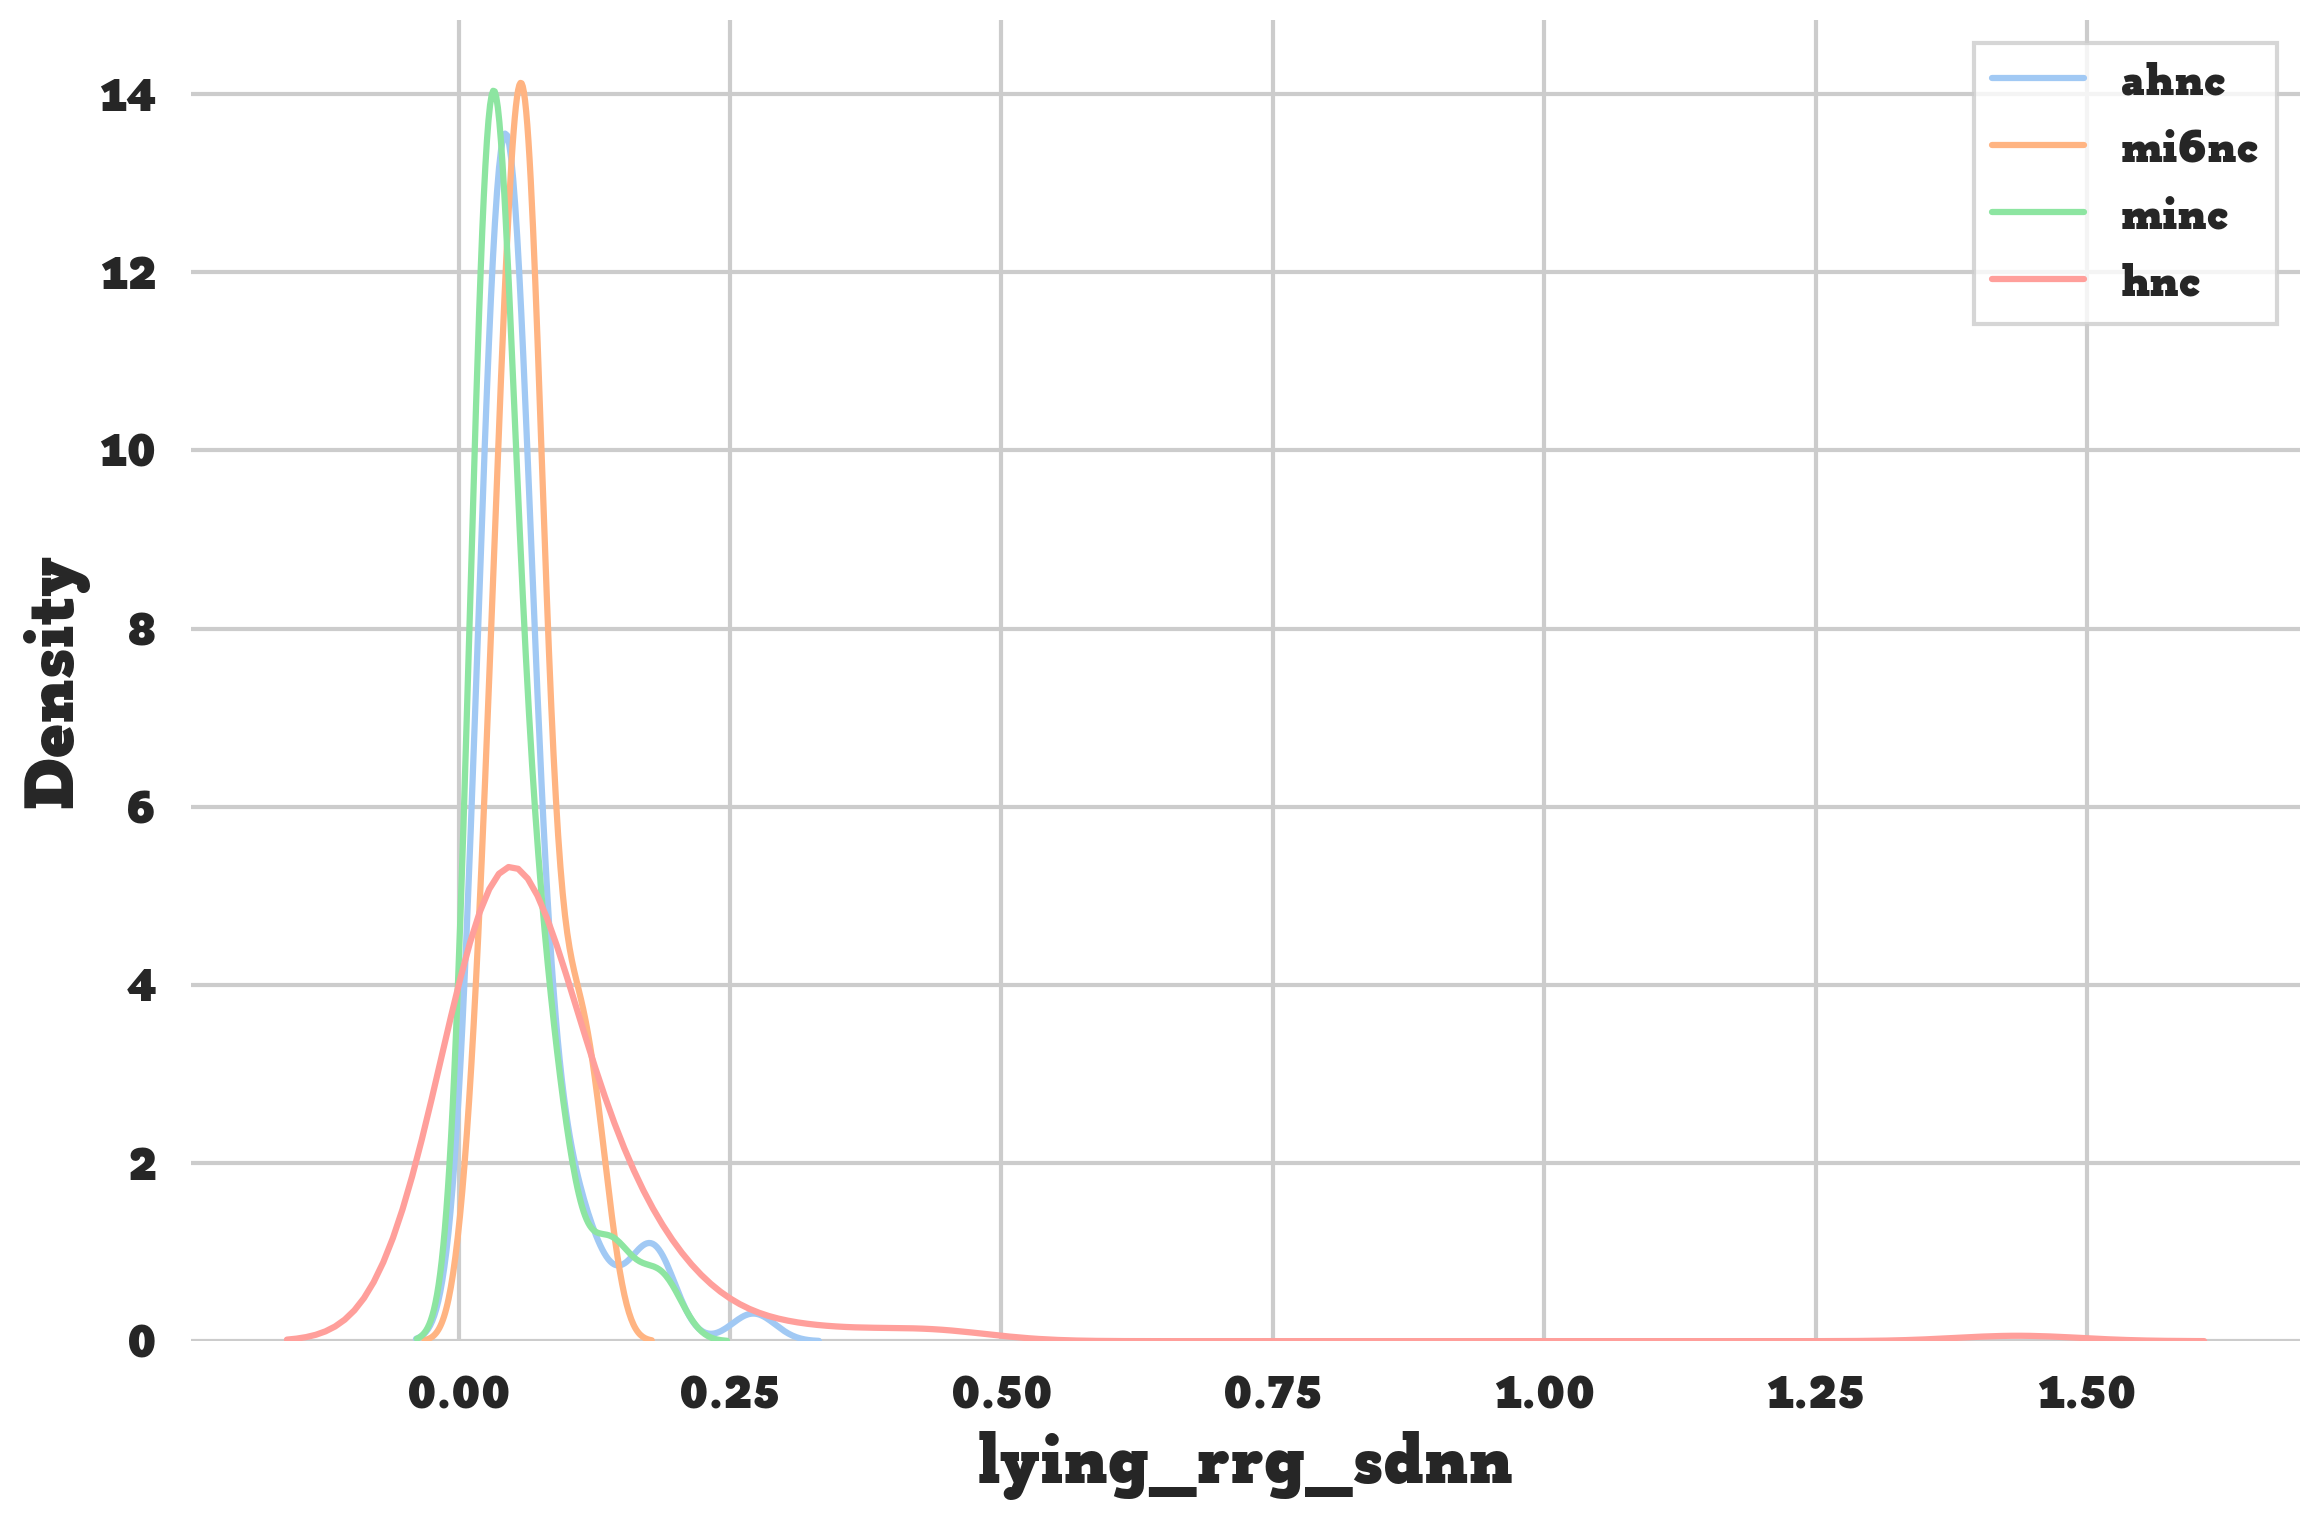

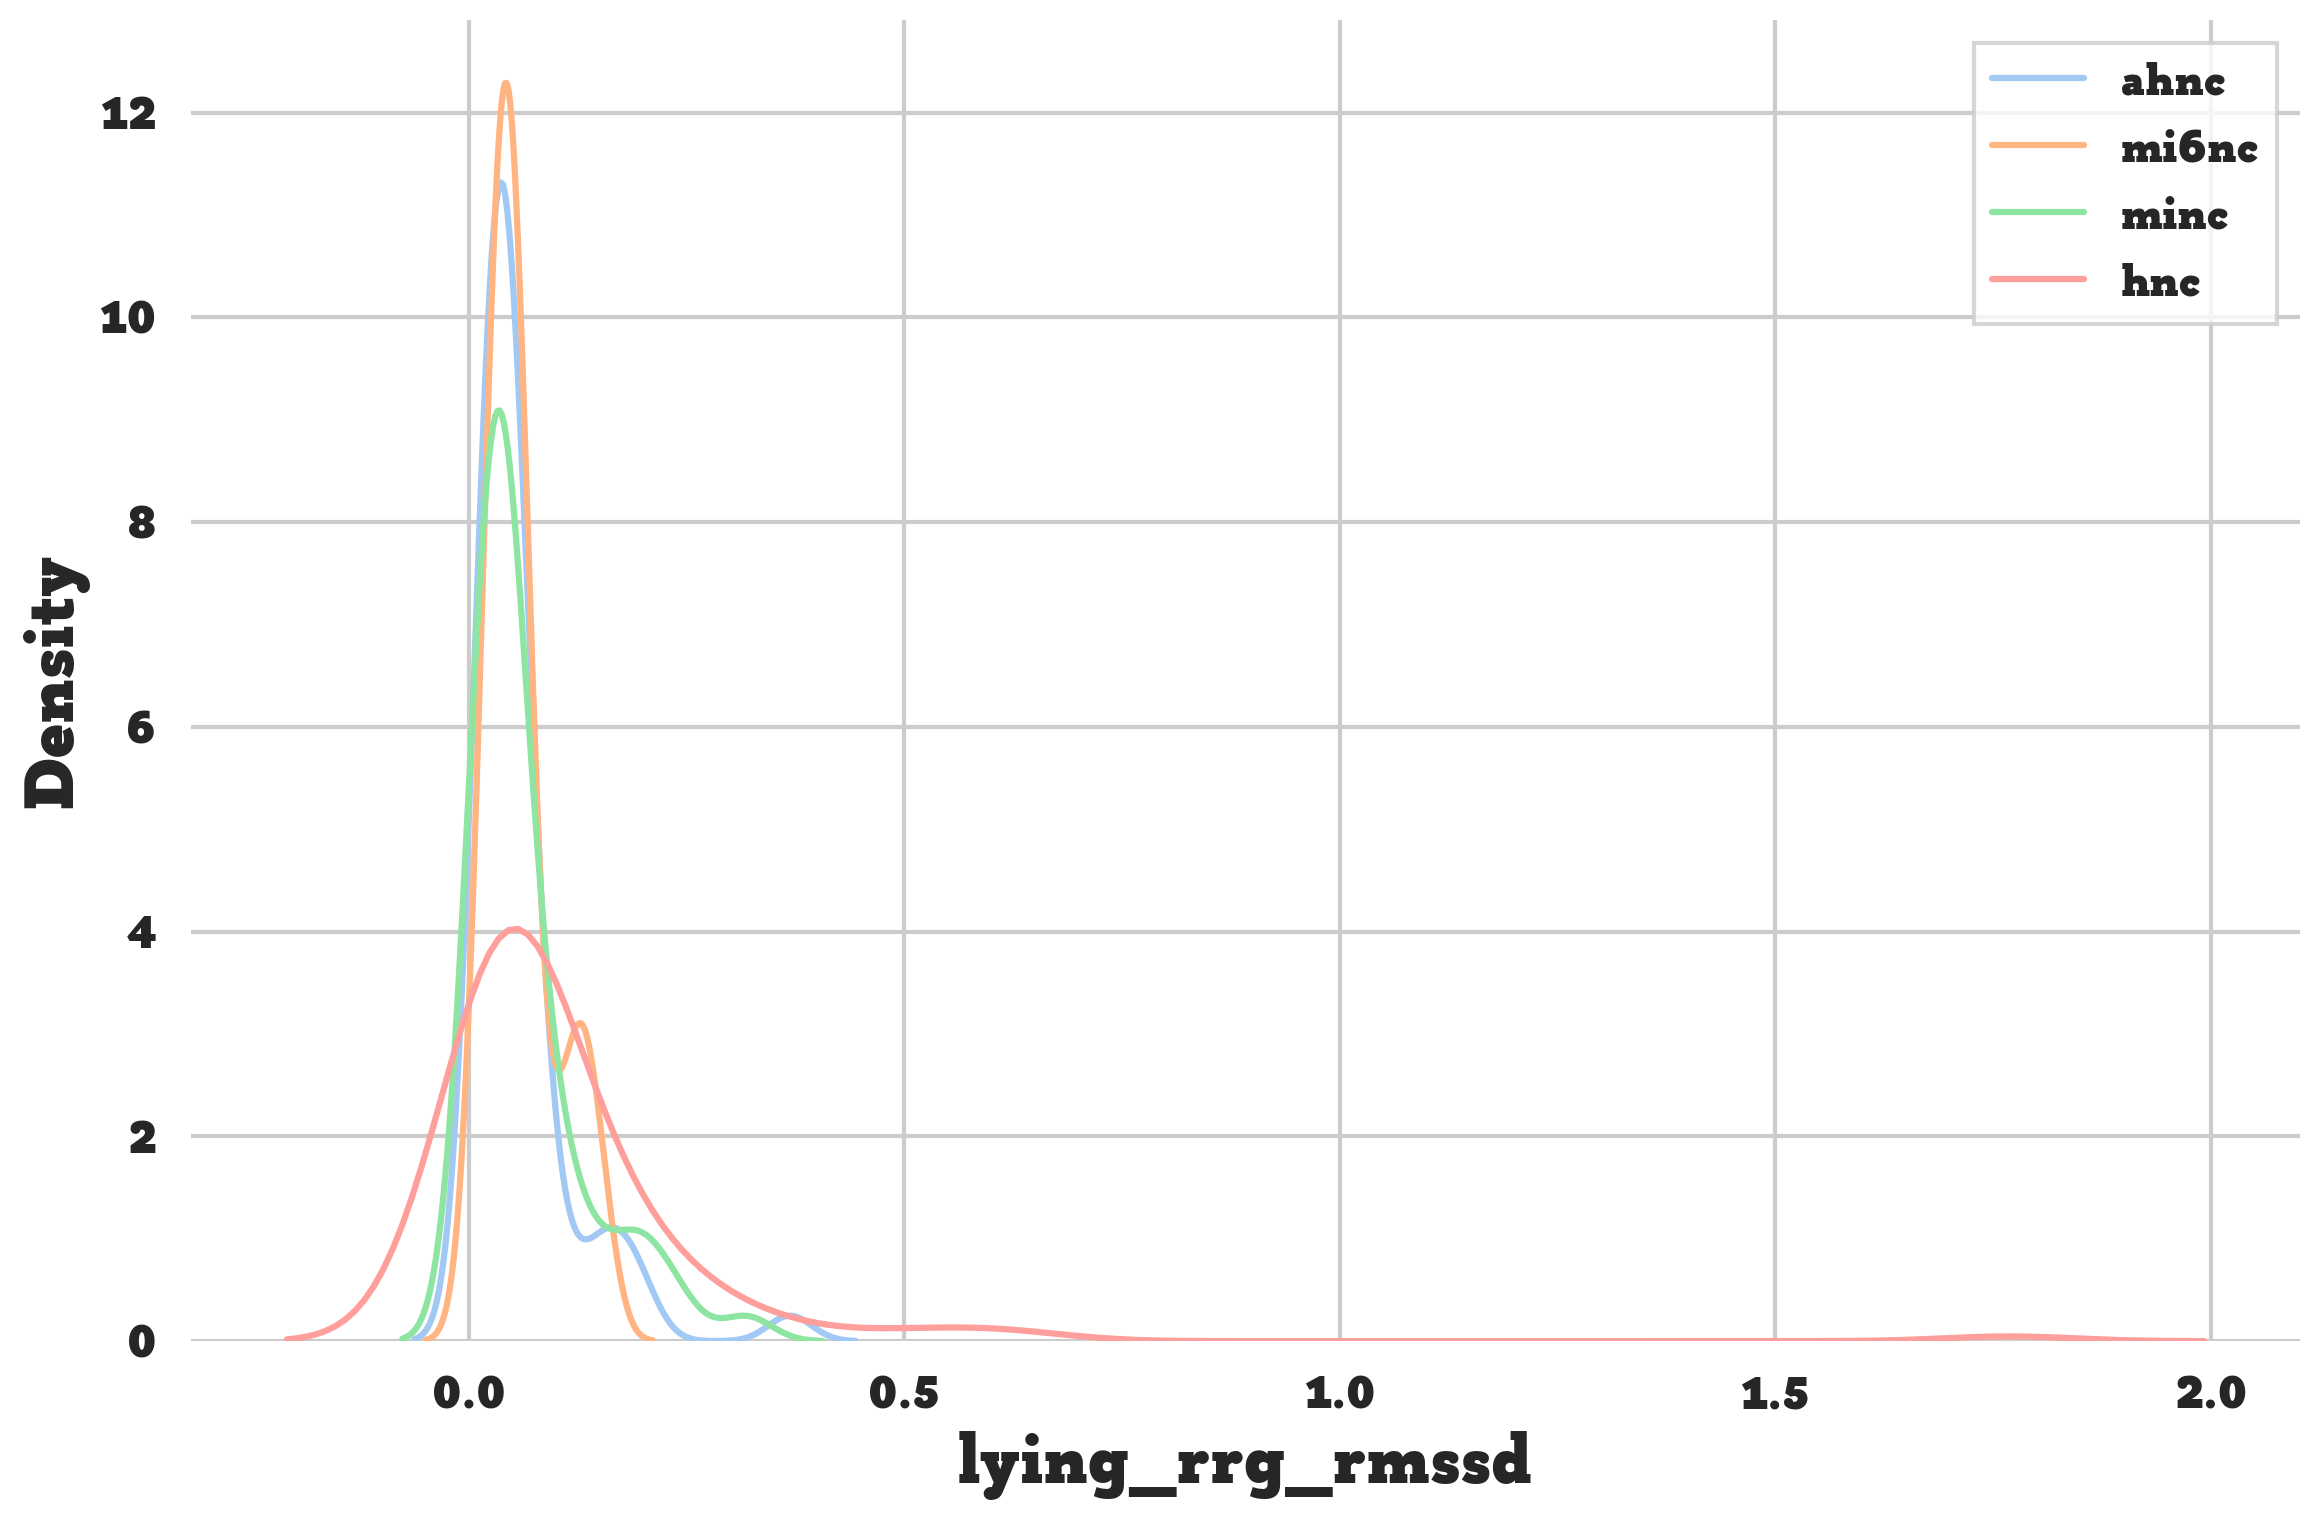

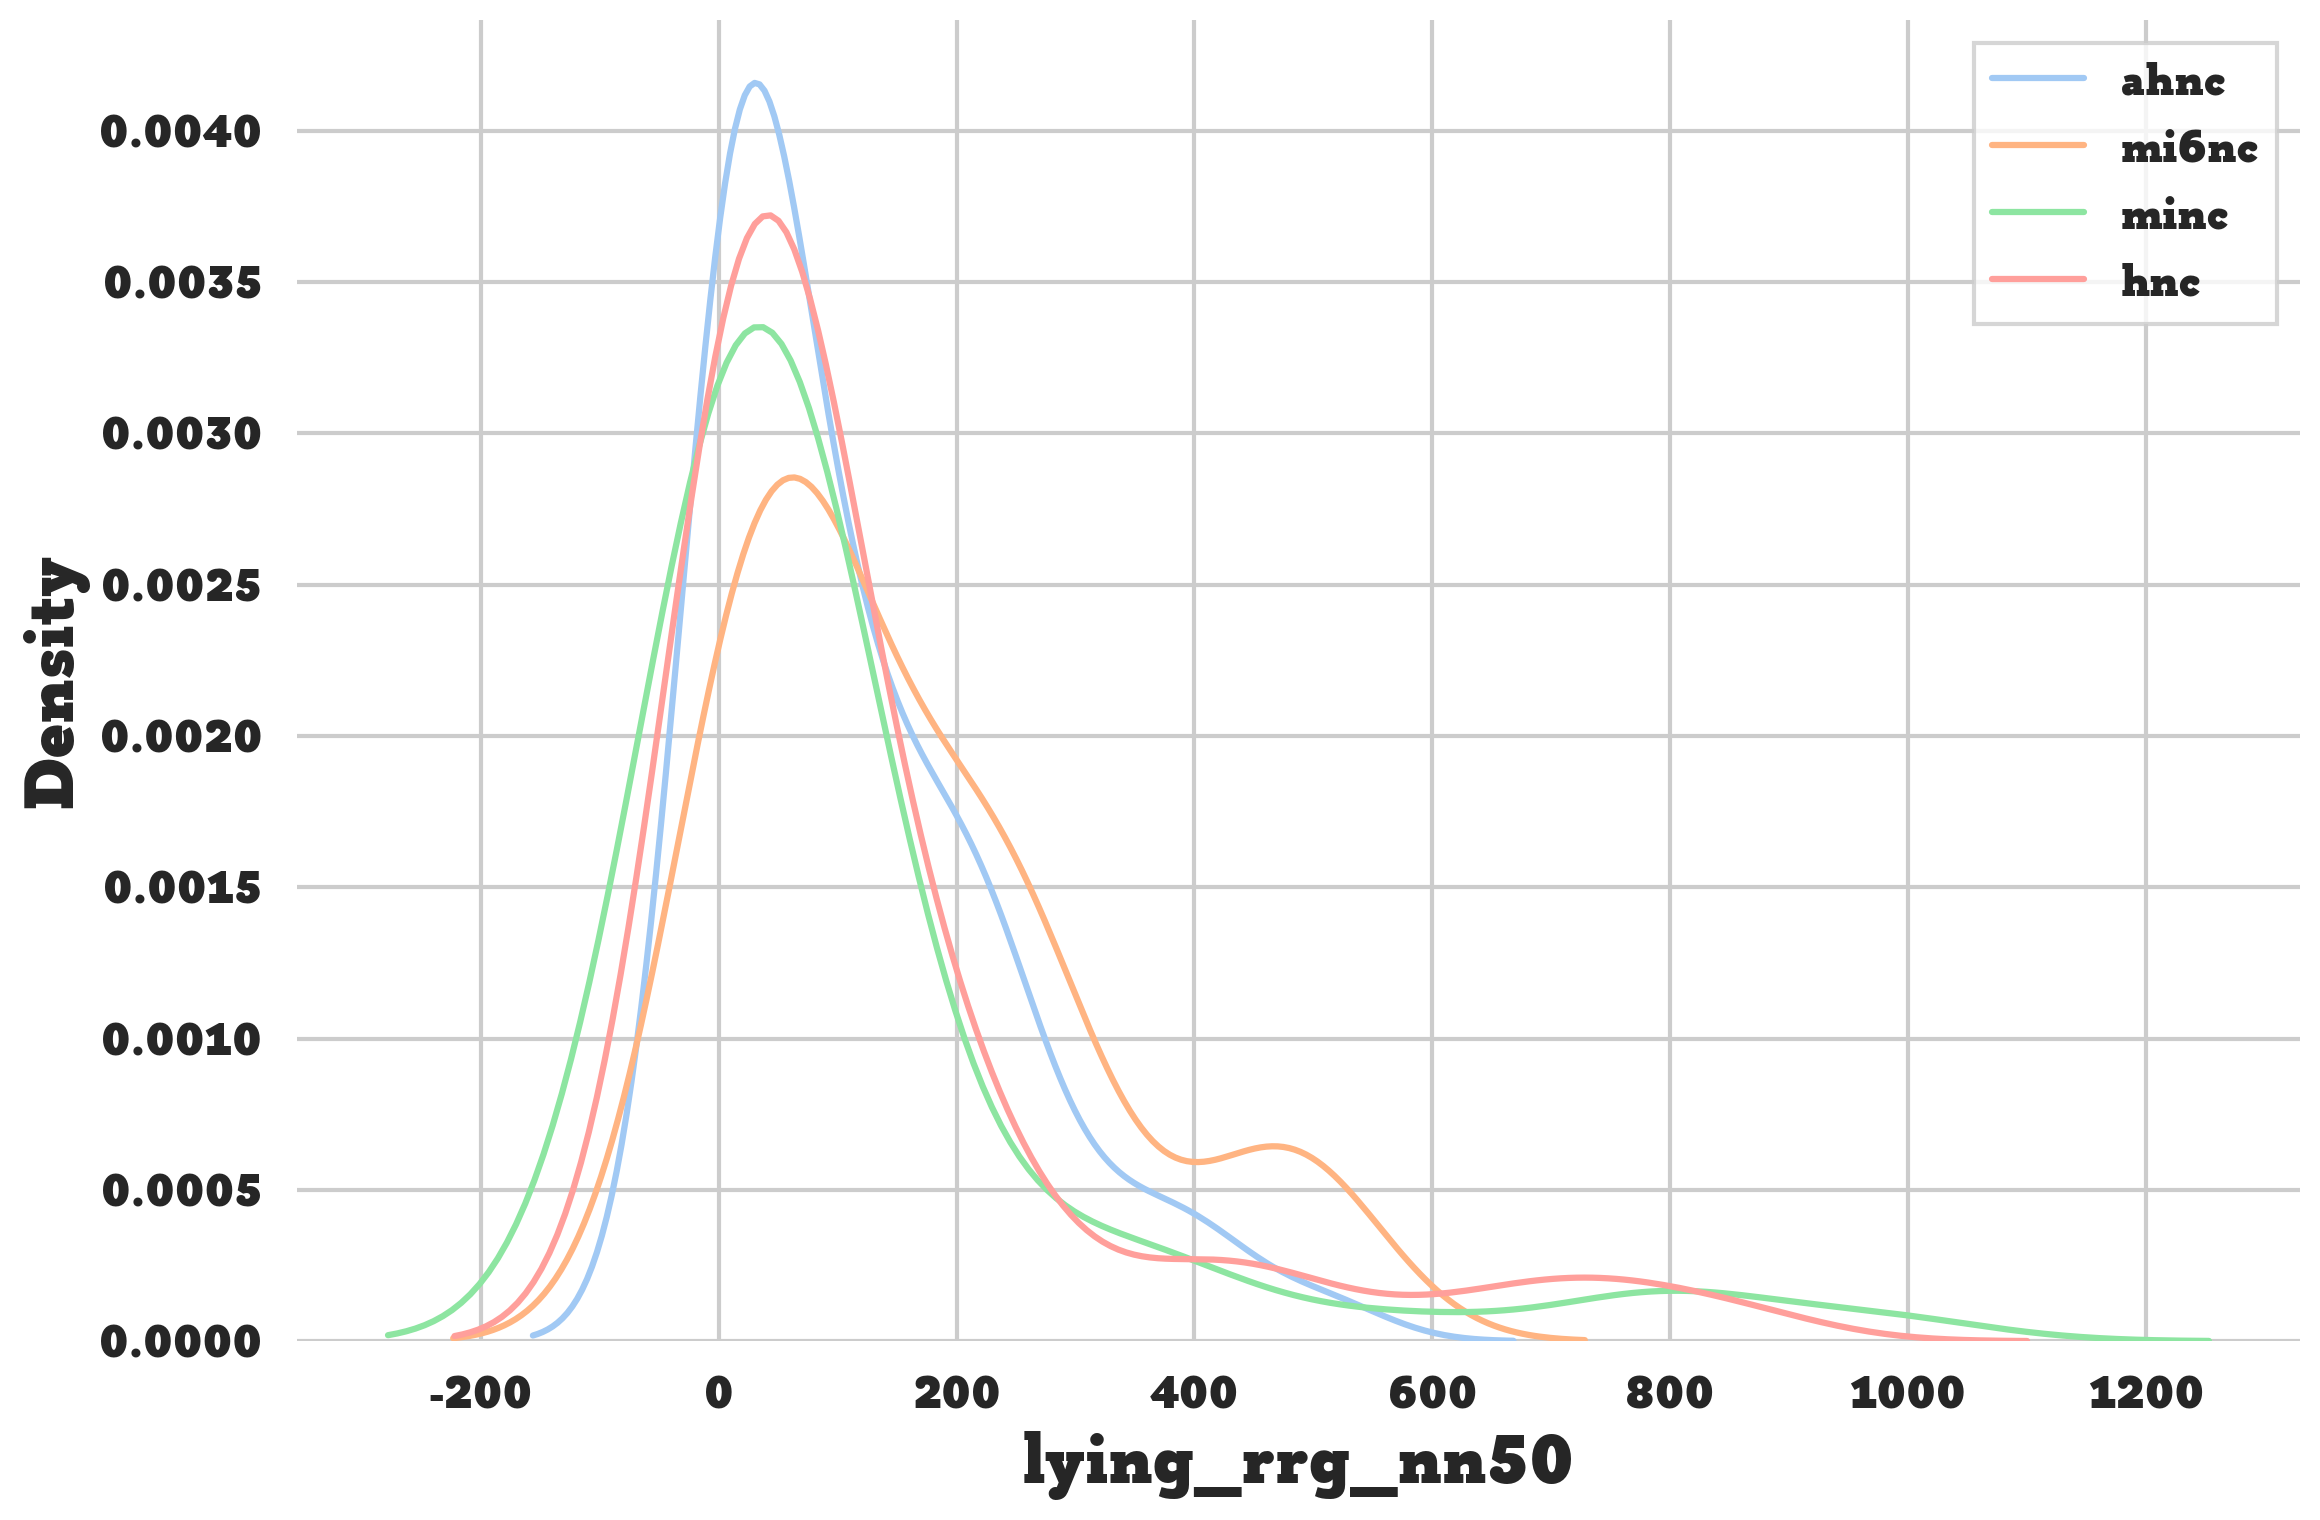

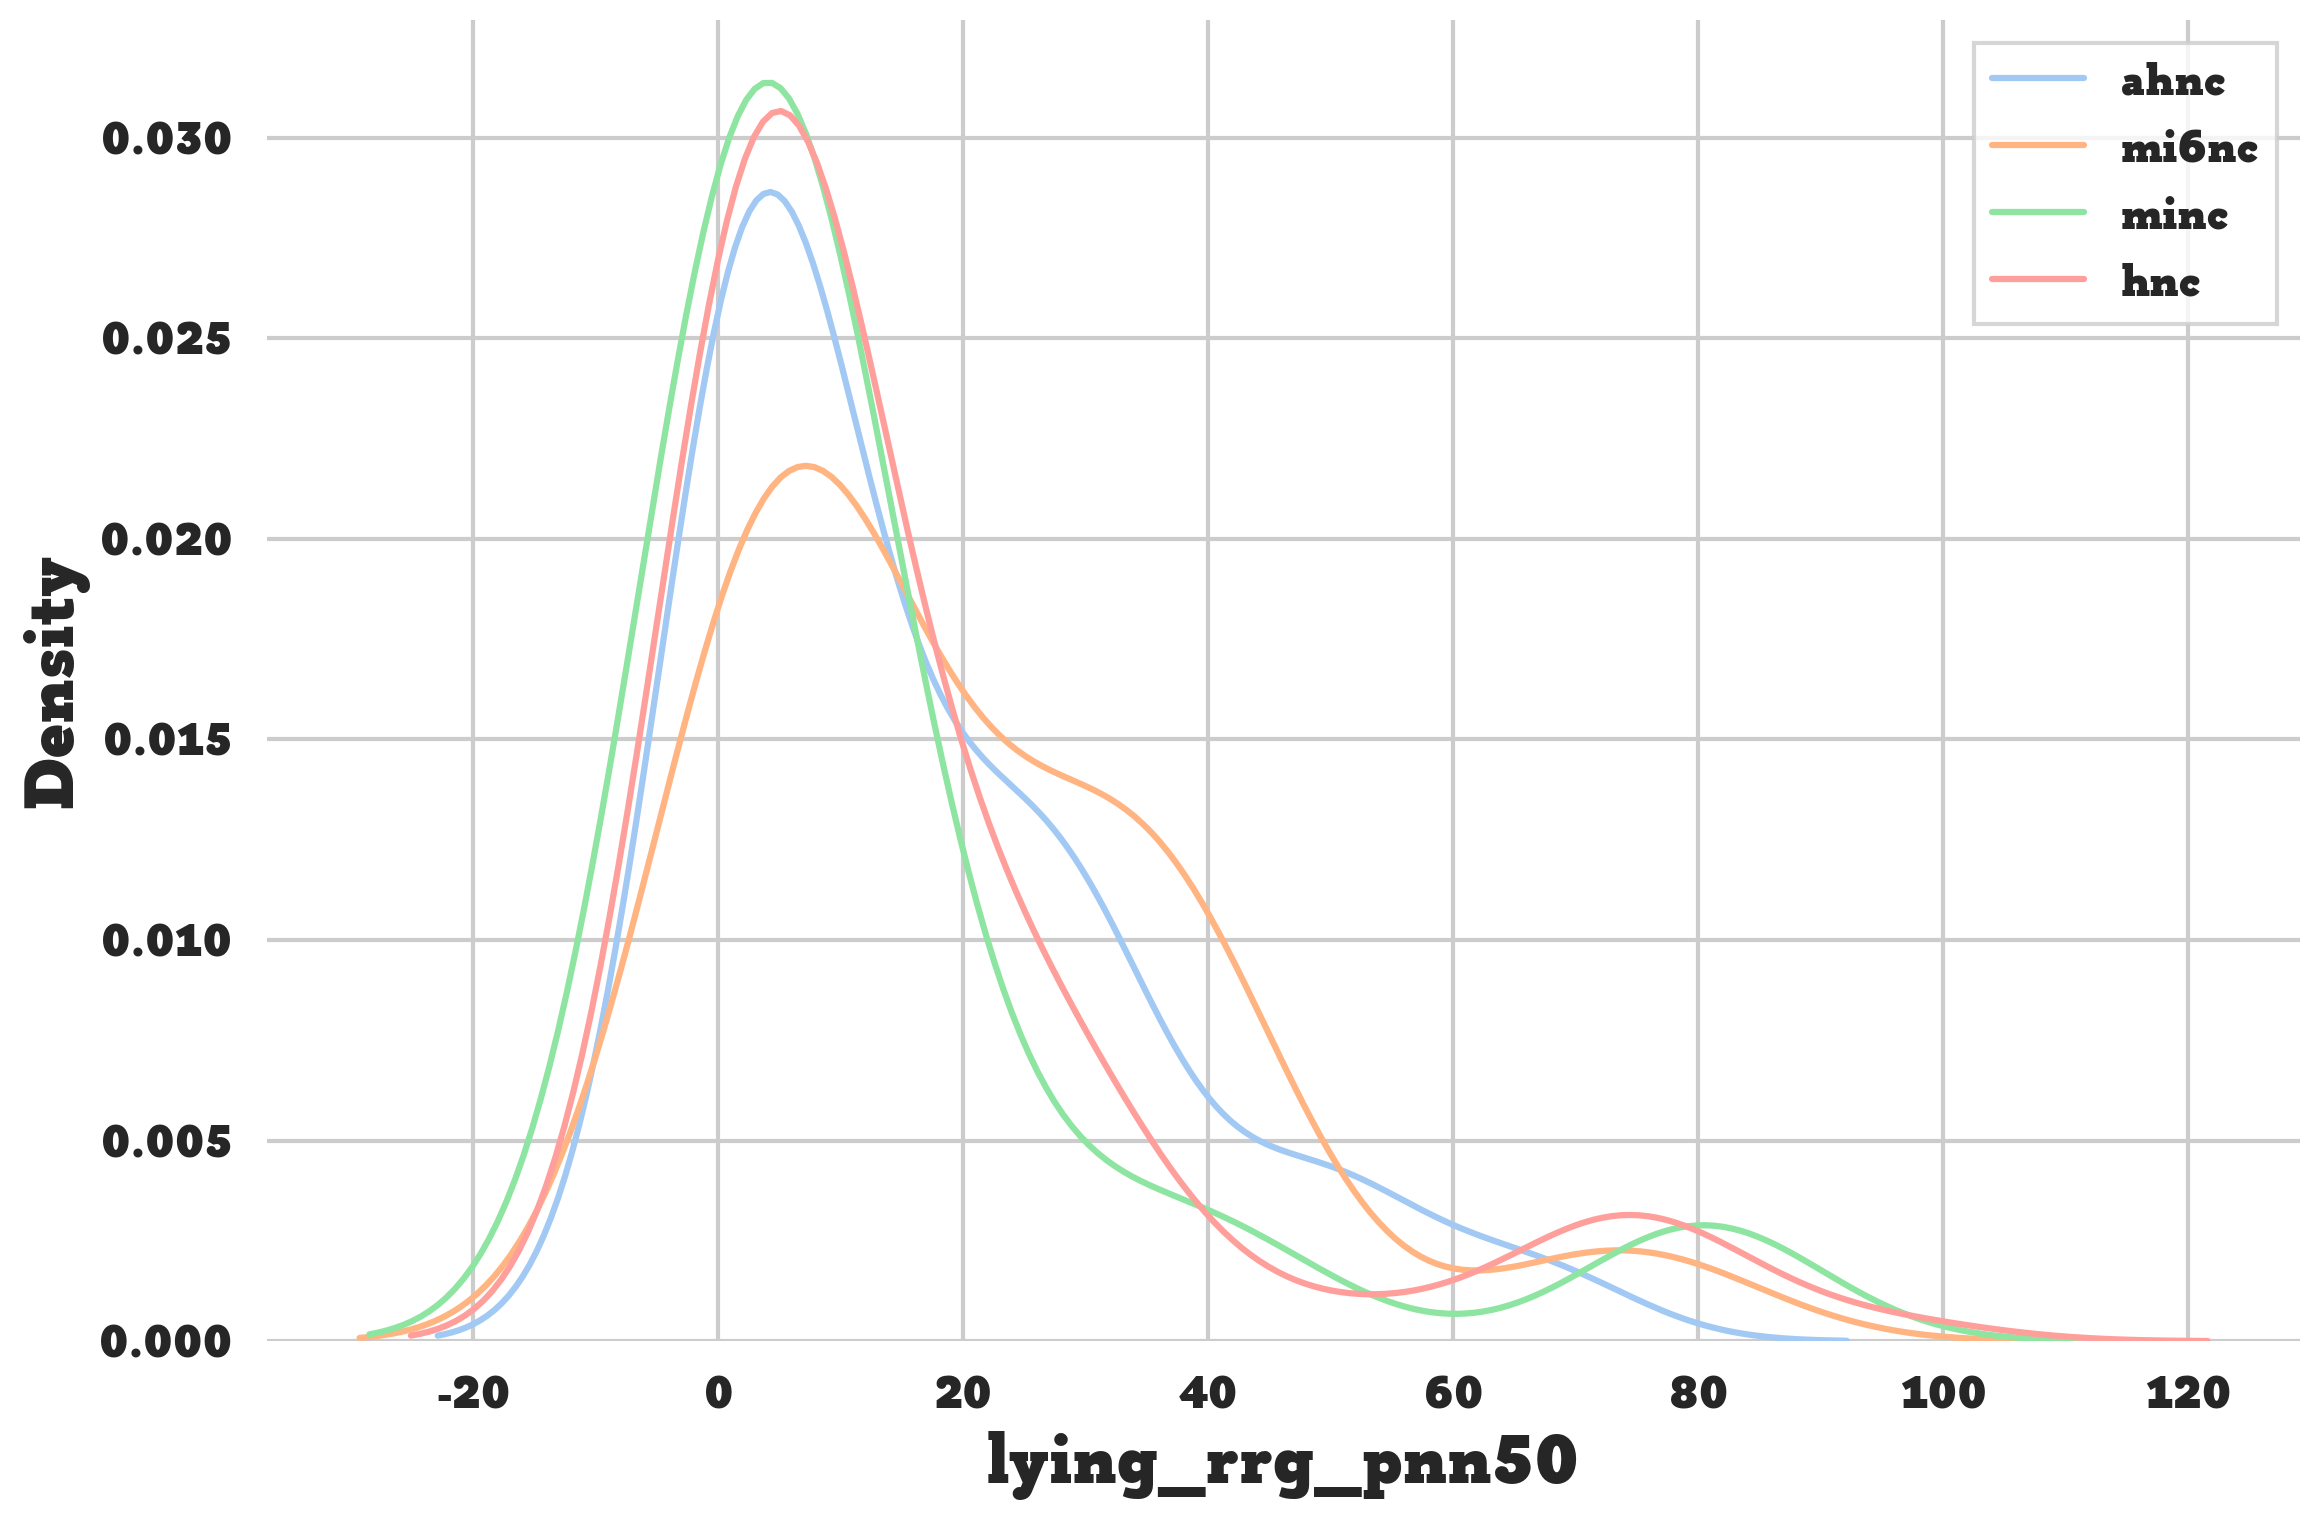

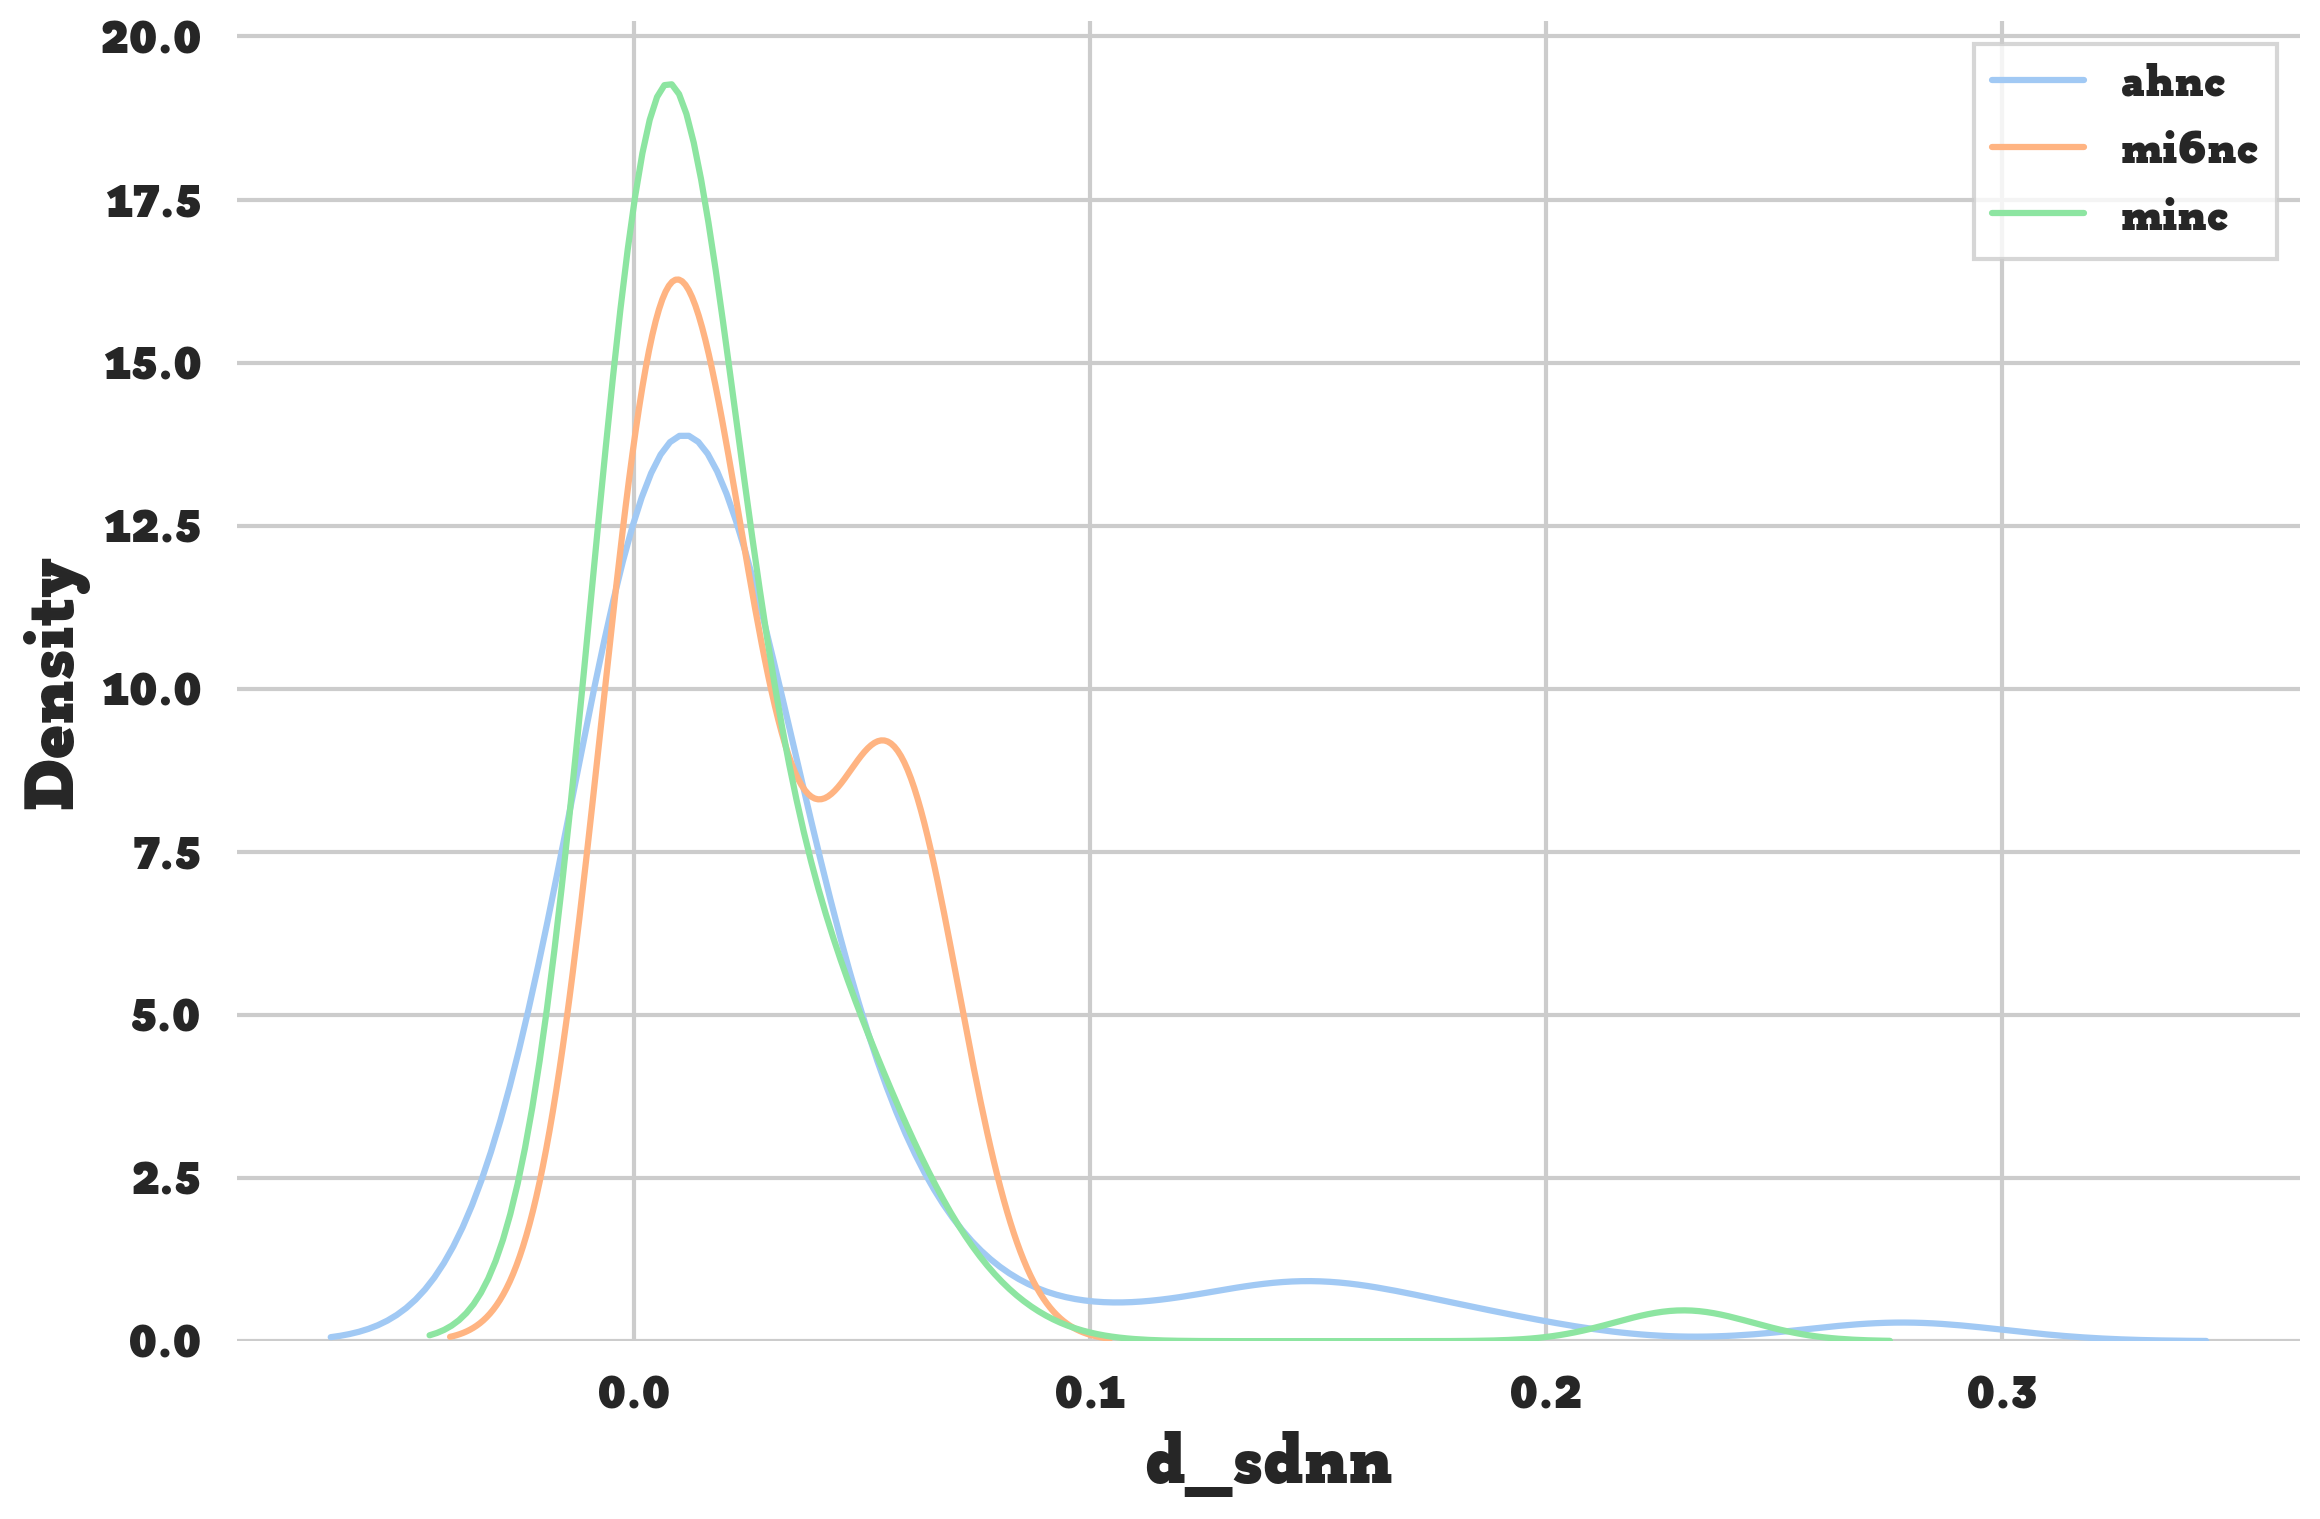

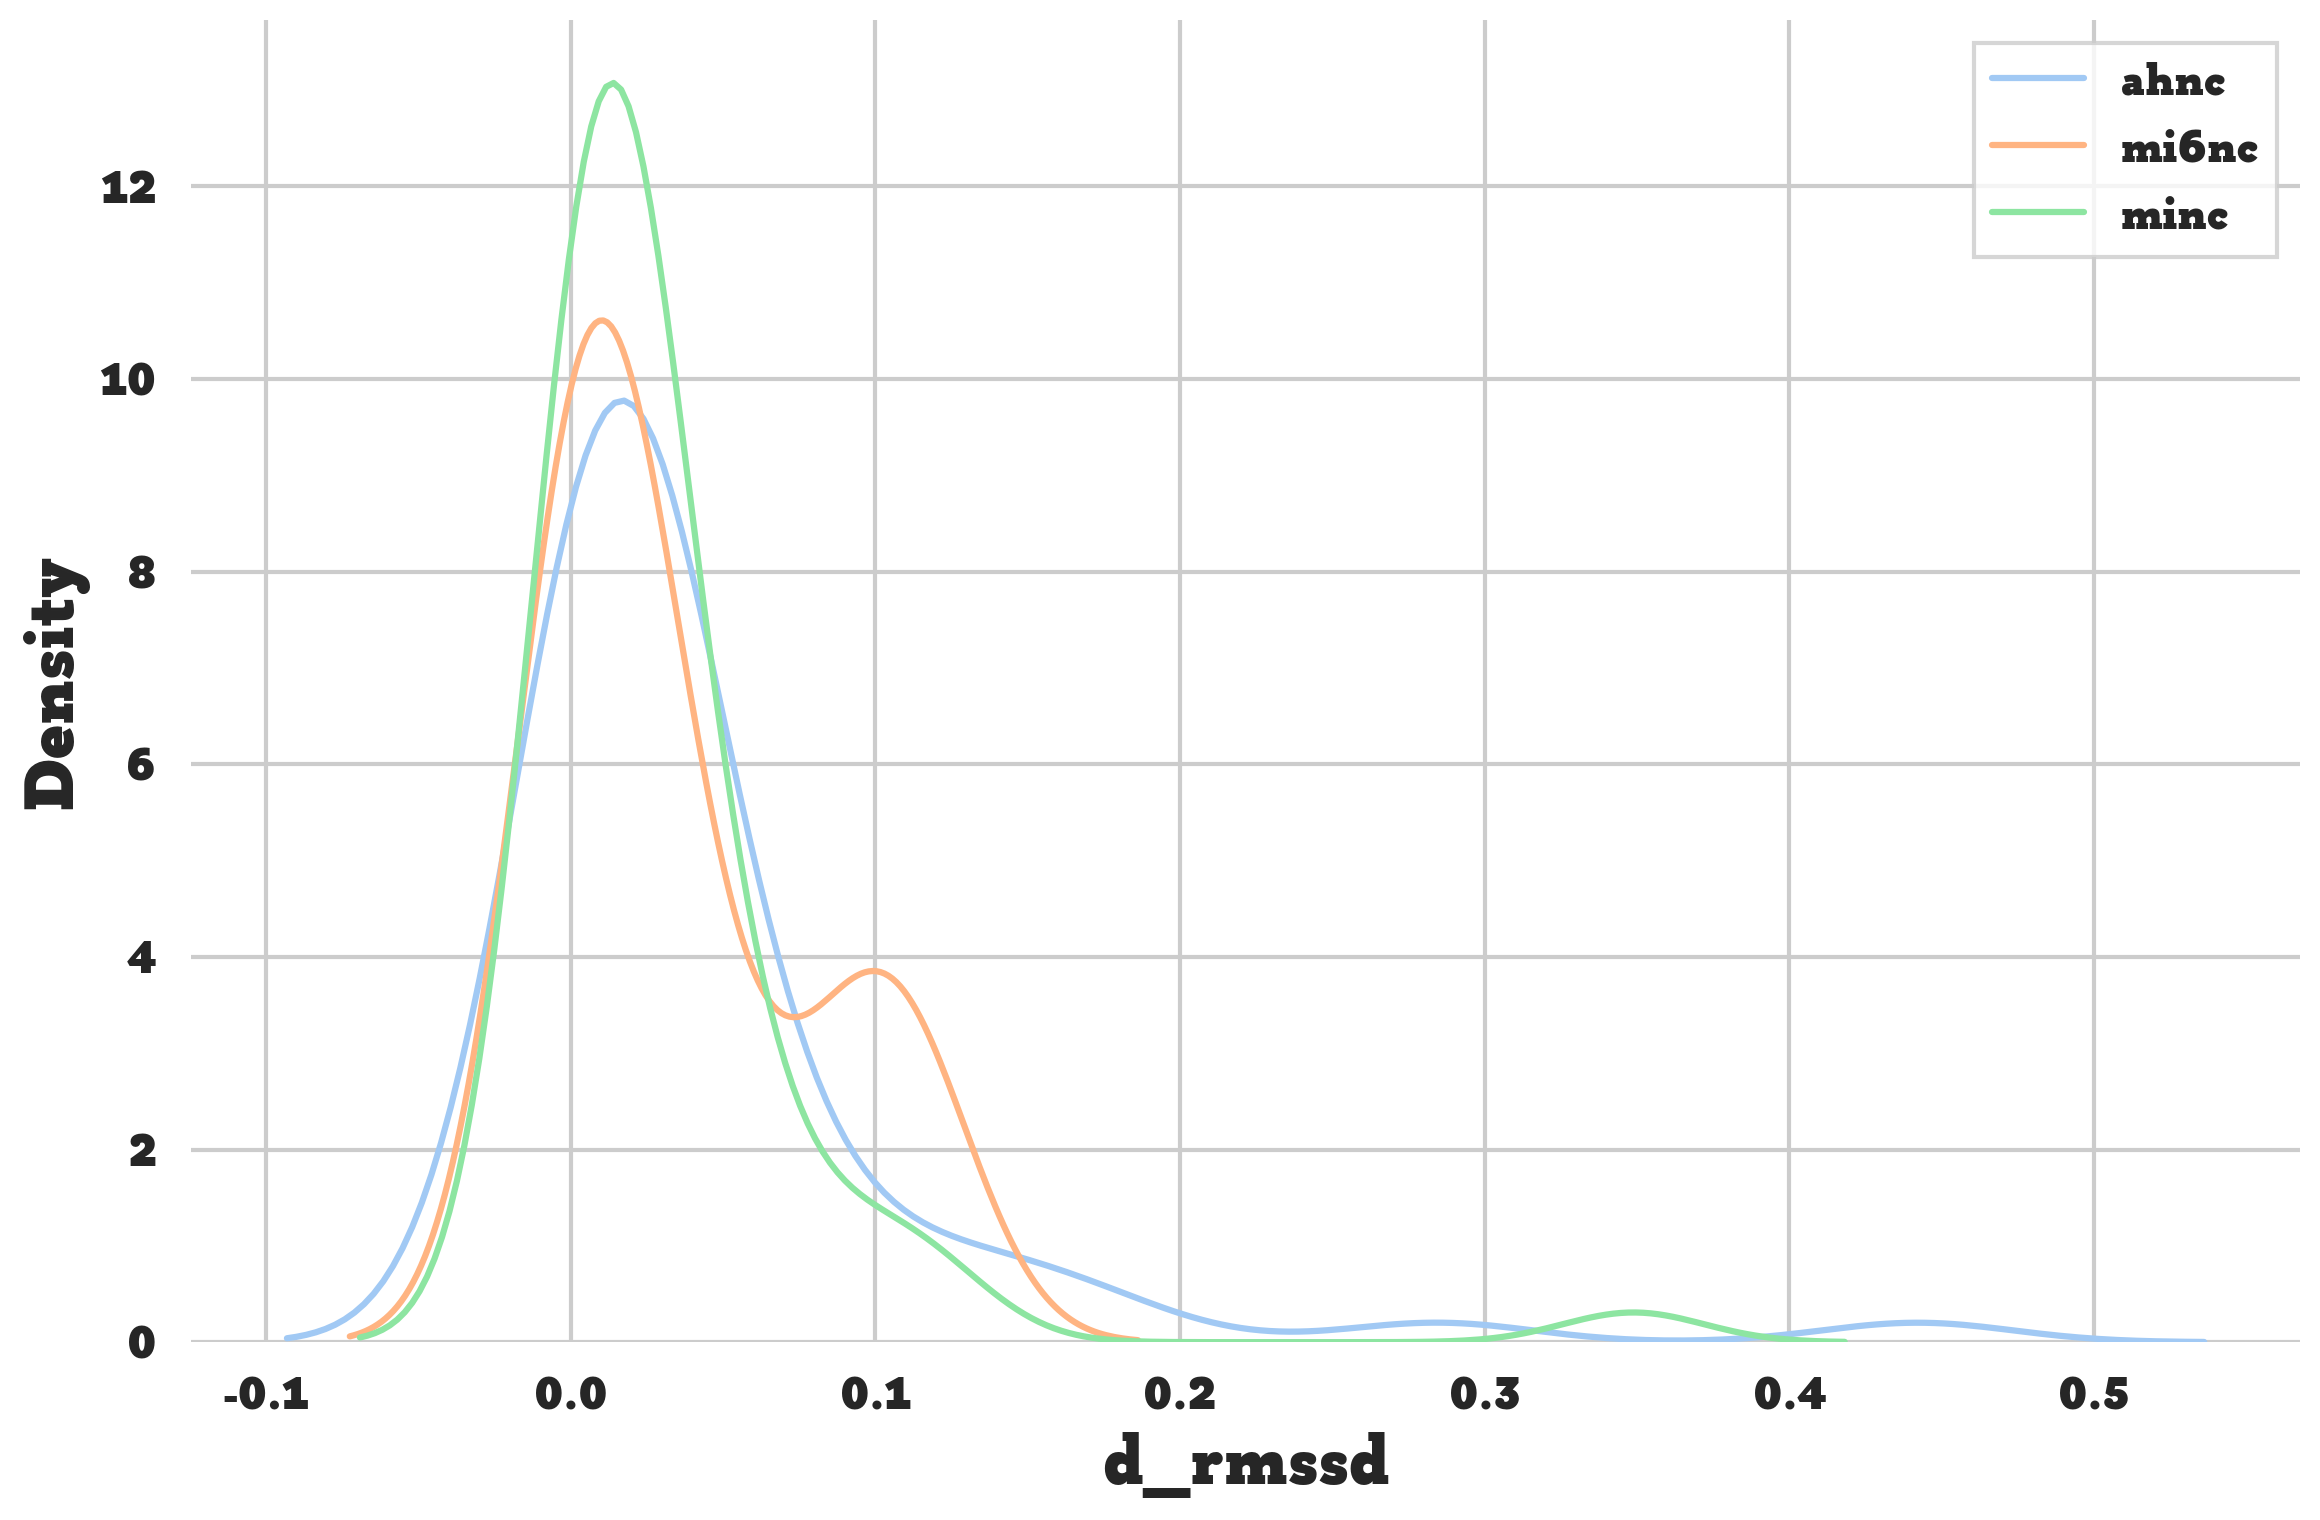

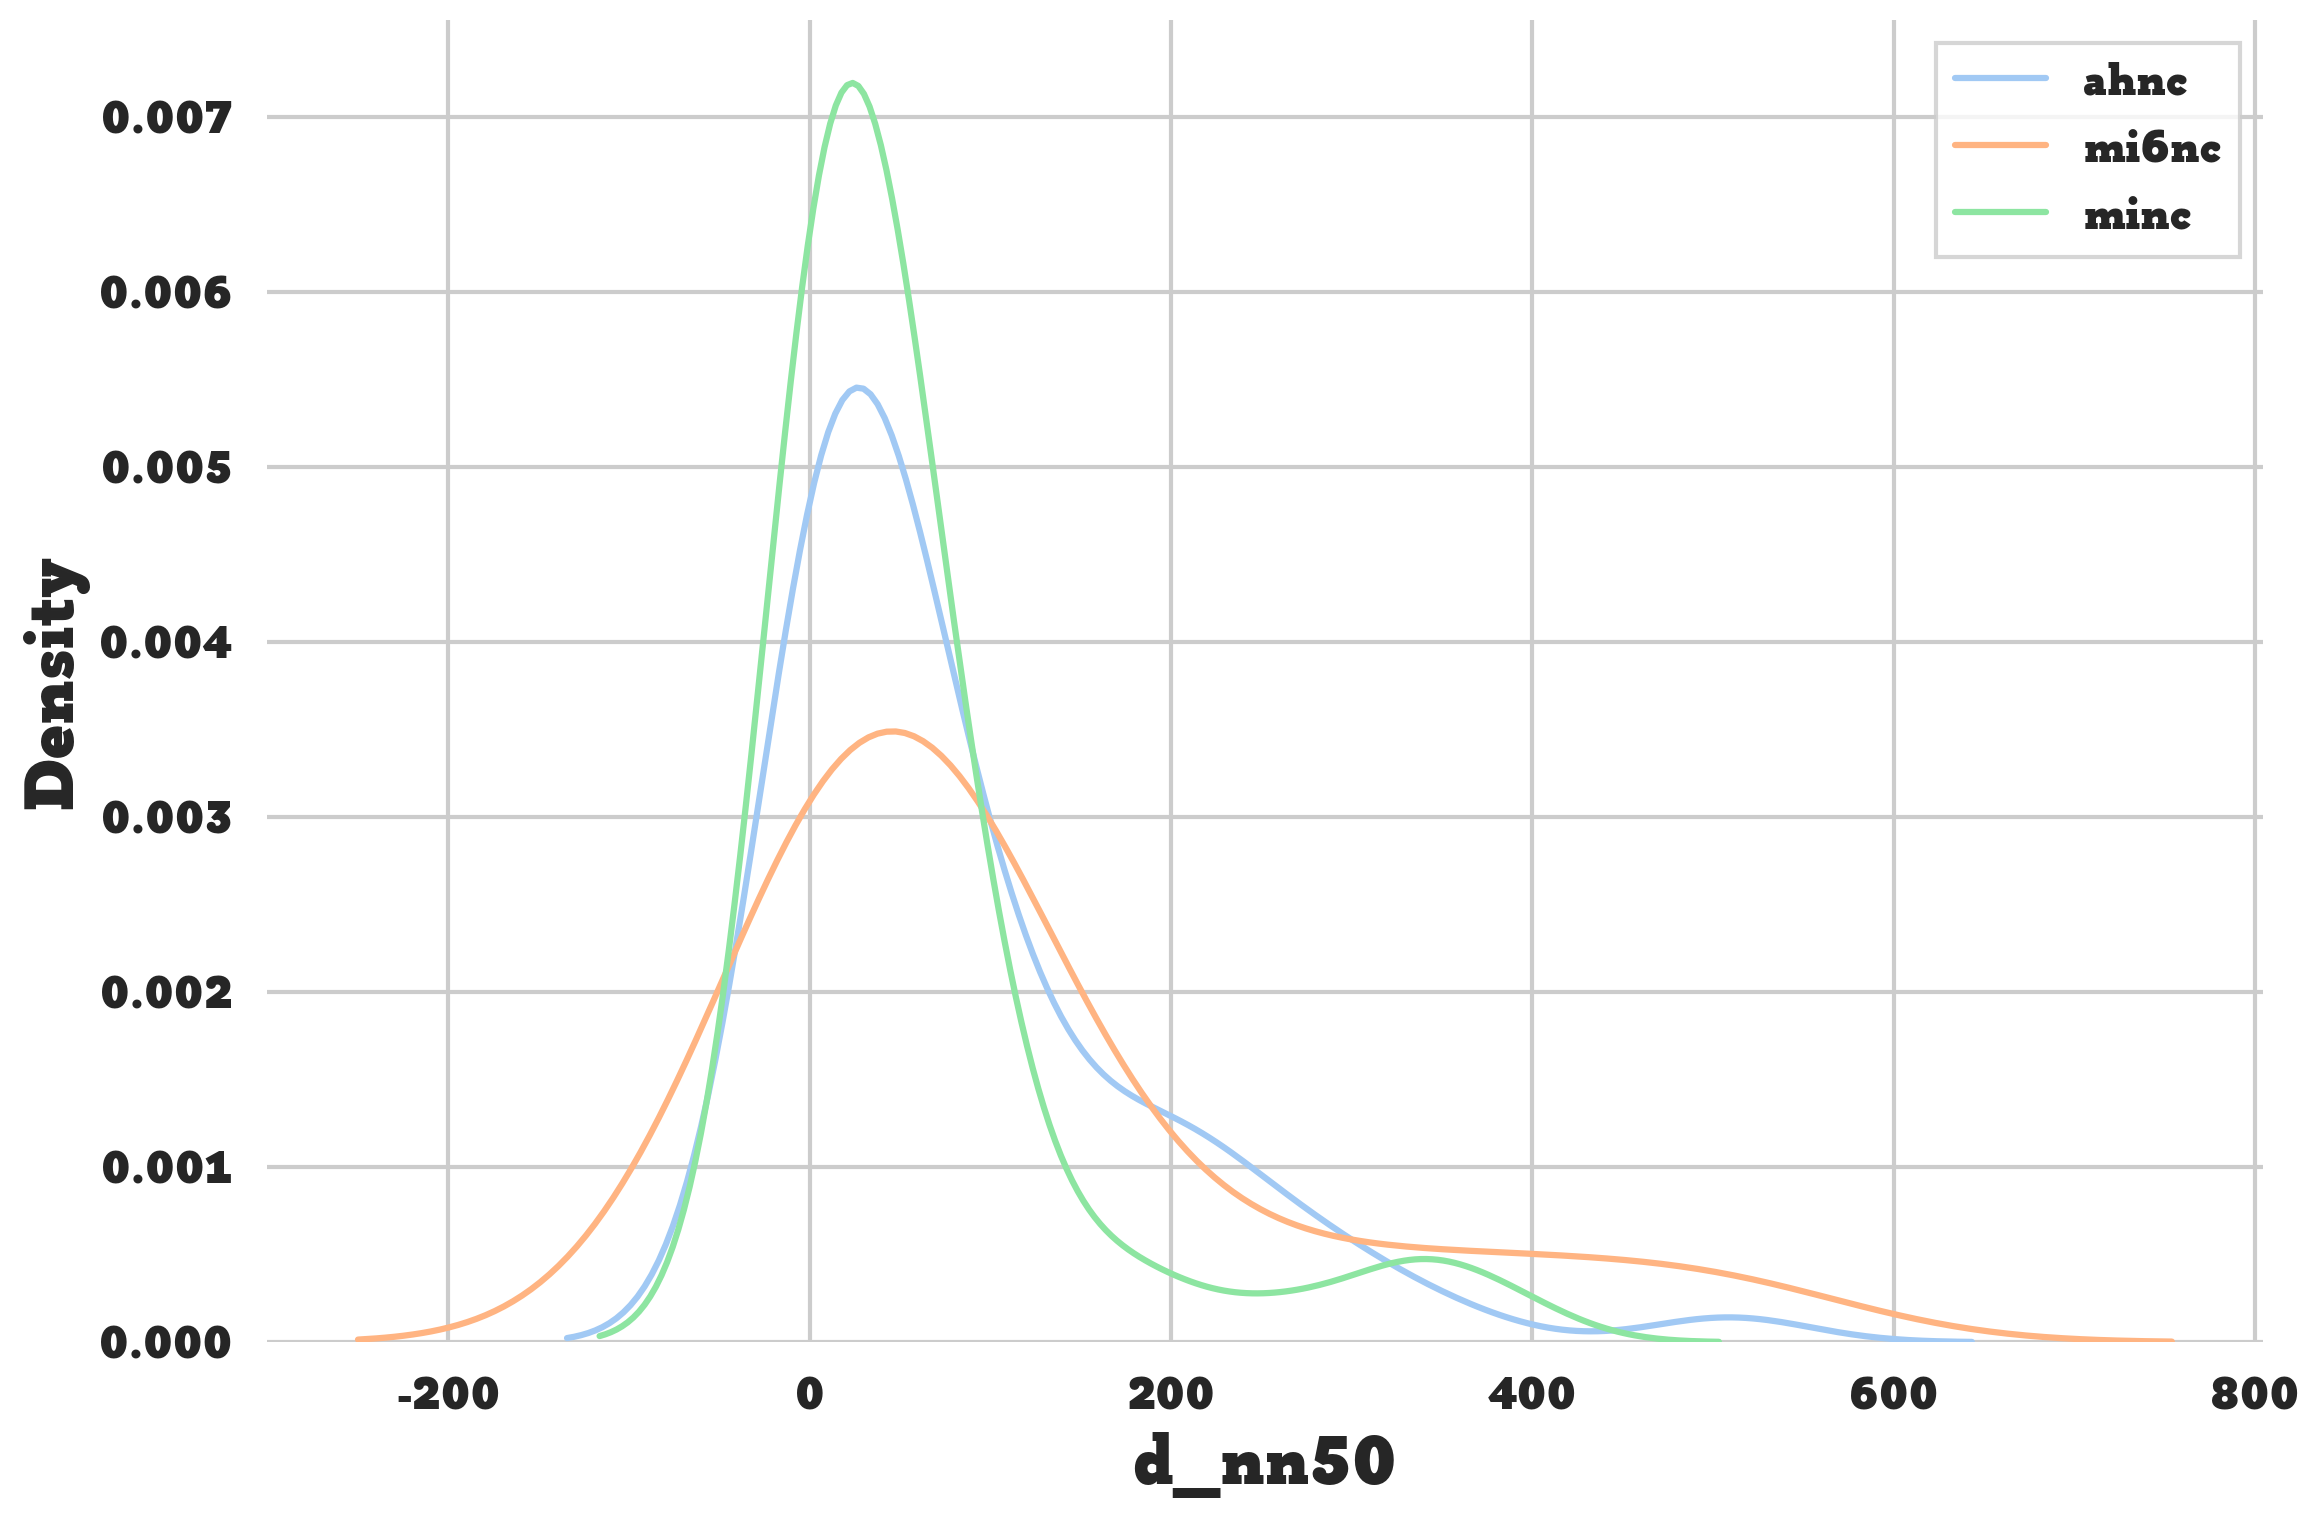

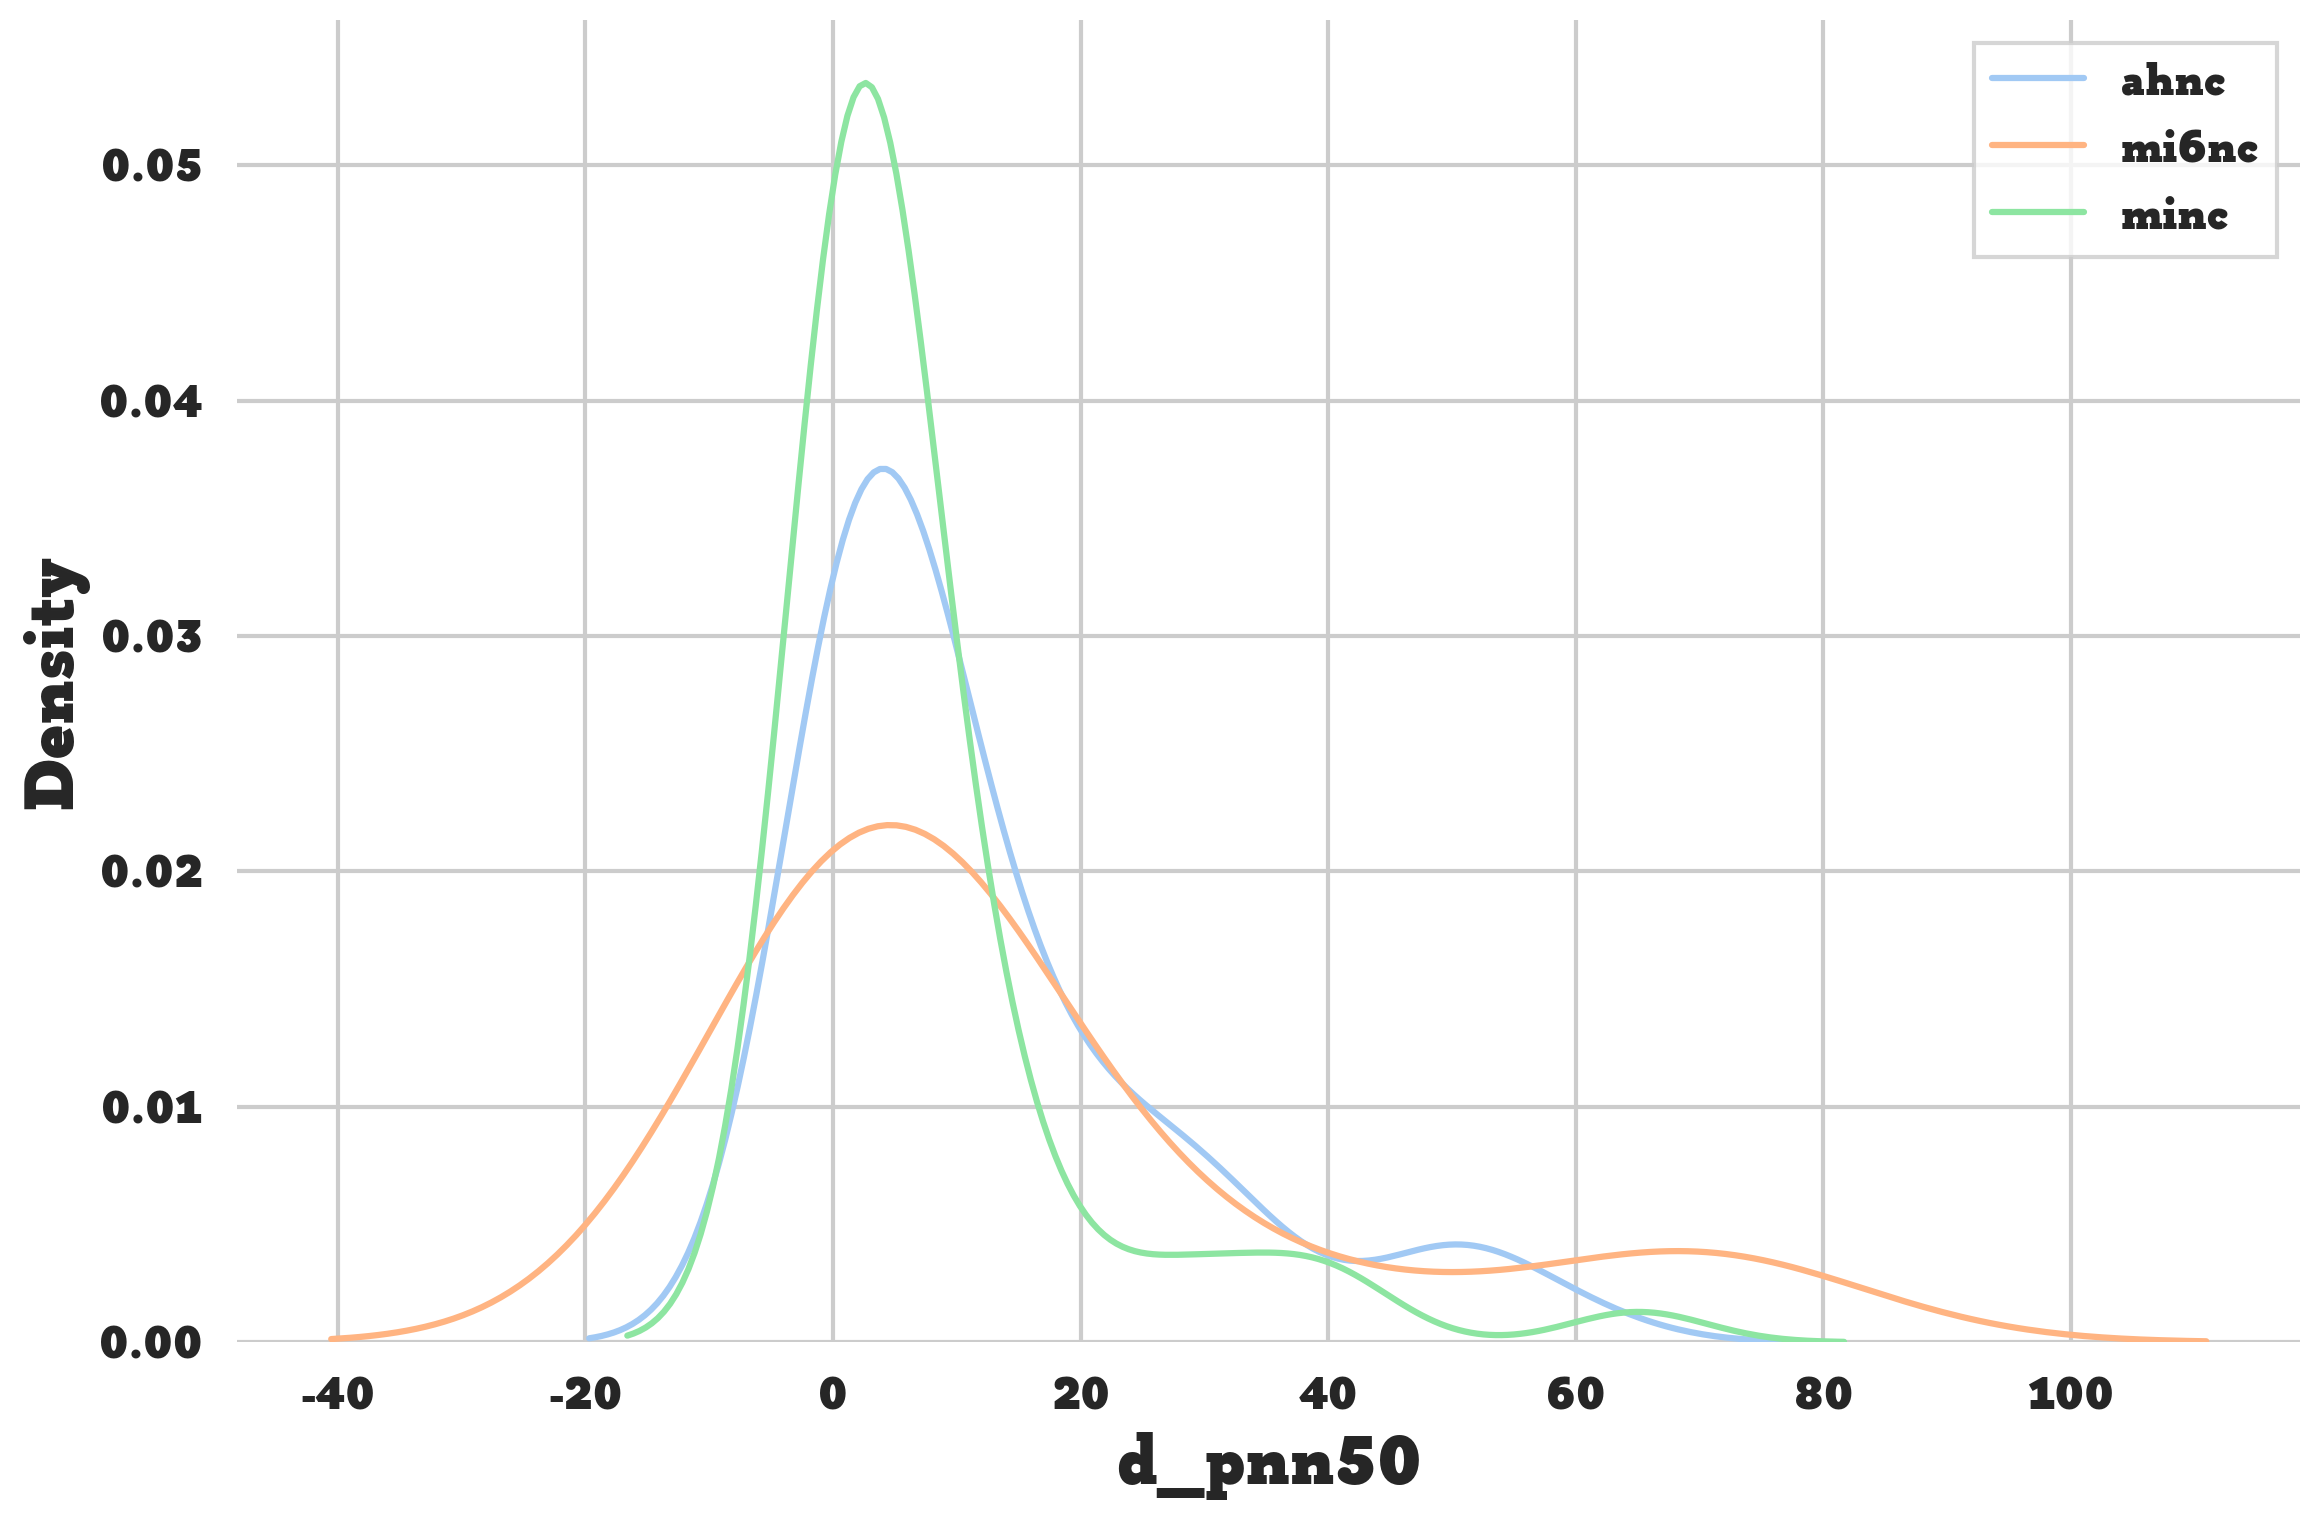

In [302]:
for i in cols:
    make_kde(datas, ["ahnc", "mi6nc", "minc", "hnc"], i)

In [303]:
t_list = []
for i, data1 in enumerate(datas):
    for j, data2 in enumerate(datas):
        for col in cols:
            if data1[col].isna().all() or data2[col].isna().all() or (i <= j):
                continue
            p_val = make_t_table(data1[col].dropna(), data2[col].dropna())
            if (not p_val):
                continue
            if p_val <= 0.05:
                t_list.append([col, get_variable_name(data1), get_variable_name(data2), p_val])


t_list = pd.Series(t_list)
t_list.head(50)

0    [stand_rrg_nn50, mi6nc, ahnc, 0.02240464386436...
1    [stand_rrg_pnn50, mi6nc, ahnc, 0.0292245595285...
2         [d_pnn50, mi6nc, ahnc, 0.048713522980087895]
3    [stand_rrg_rmssd, mi6nc, hnc, 0.00972564226089...
4    [lying_rrg_rmssd, minc, ahnc, 0.00652071746254...
5    [lying_rrg_rmssd, minc, hnc, 0.007385211146639...
6    [lying_rrg_sdnn, minc, mi6nc, 0.01606606870395...
7    [lying_rrg_rmssd, minc, mi6nc, 0.0230773021243...
dtype: object